# Import libraries & set options

In [1]:
!pip install tqdm
from tqdm import tqdm_notebook

  Using cached https://files.pythonhosted.org/packages/6c/4b/c38b5144cf167c4f52288517436ccafefe9dc01b8d1c190e18a6b154cd4a/tqdm-4.31.1-py2.py3-none-any.whl
You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import numpy as np
import random as rn
import datetime
import gc;

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 300)

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, log_loss
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# libs for FFM embedding (absent in final model)
import tensorflow as tf
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dot, Reshape, Add, Subtract
from keras import objectives
from keras import backend as K
from keras import regularizers 
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

Using TensorFlow backend.


Fix `seed` to make model reproducable

In [3]:
def init_seeds(seed):
    
    os.environ['PYTHONHASHSEED'] = '0'
    
    np.random.seed(seed)
    rn.seed(seed)

    # Force TensorFlow to use single thread.
    # Multiple threads are potential source of non-reproducible results.
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

    # The below tf.set_random_seed() will make random number generation
    tf.set_random_seed(seed)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    
    return sess

sess = init_seeds(seed=0)

Read last purchase date called `reference_date` for each `card_id` (notebook `find_last_transaction.ipynb`).

In [4]:
reference_date = pd.read_csv('saved_features_24-02/reference_date.csv', index_col=0, parse_dates=['reference_date'])
 
reference_date['reference_year'] = reference_date['reference_date'].dt.year.astype('category')
reference_date['reference_month'] = reference_date['reference_date'].dt.month.astype('category')
reference_date['reference_woy'] = reference_date['reference_date'].dt.weekofyear.astype('category')

# Load train/test

In [6]:
def load_train_test(path_to_tr, path_to_te):
    
    # read data
    tr = pd.read_csv(path_to_tr)
    te = pd.read_csv(path_to_te)
    
    # set up outliers in train
    tr['outliers'] = 0
    tr.loc[tr['target'] < -30, 'outliers'] = 1
    
    # set target as nan in test
    te['target'] = np.nan
    
    # merge train and test
    df = tr.append(te)
    del tr, te
    gc.collect()
    
    # parse date features
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    
    df['start_year']  = df['first_active_month'].dt.year.astype(str)
    df['start_month'] = df['first_active_month'].dt.month.astype(str)
    df['start_woy']   = df['first_active_month'].dt.weekofyear.astype(str)
    
    df['start_year_month'] = (df['start_year'] + '_' + df['start_month']).astype('category')
    df['start_year_woy'] = (df['start_year'] + '_' + df['start_woy']).astype('category')
    
    del df['start_year'], df['start_month'], df['start_woy']
    gc.collect()
    
    # add reference_date for new features
    df = df.merge(reference_date, on='card_id', how='left')
    
    # add new features
    df['elapsed_time'] = ((df['reference_date'] - df['first_active_month']).dt.days) // 30
    df['elapsed_time_feb'] = ((np.datetime64('2018-02-01') - df['first_active_month']).dt.days) // 30
    
    df_train = df[df['target'].notnull()]
    df_test = df[df['target'].isnull()]
    
    return df_train, df_test

df_train, df_test = load_train_test(path_to_tr='all/train.csv', path_to_te='all/test.csv')

In [7]:
def target_encoding(df, feature_to_enc, drop_col=False):
    """Target encoding with smoothing regularizaltion."""
    
    agg_values = df.groupby(feature_to_enc)['target'].agg(['sum', 'count']).reset_index(drop=False)
    
    # we will take median due to some important outliers in target
    agg_values['global_median'] = df['target'].median()
    
    # let regularization coefficient to be
    alpha = agg_values['count'].mean() // 5
    agg_values[feature_to_enc + '_target_enc'] = (
        agg_values['sum'] + alpha * agg_values['global_median']) / (agg_values['count'] + alpha)
    
    df = df.merge(agg_values[[feature_to_enc, feature_to_enc + '_target_enc']], on=feature_to_enc, how='left')
    
    if drop_col:
        df = df.drop([feature_to_enc], axis=1)
    
    return df


for feature in ['feature_1', 'feature_2', 'feature_3']:
    
    # for train 
    df_train = target_encoding(df=df_train, feature_to_enc=feature, drop_col=False)
    
    # for test
    feature_target_enc = feature + '_target_enc'
    df_test[feature_target_enc] = df_test[feature].map(df_train.groupby(feature)[feature_target_enc].mean().to_dict())
    
    # drop this feature
#     df_train = df_train.drop([feature], axis=1)
#     df_test = df_test.drop([feature], axis=1)

Add `reference_woy` features

In [8]:
woy_purchase = pd.read_csv('saved_features_24-02/woy_purchase.csv', index_col=0)
woy_purchase['reference_woy'] = woy_purchase['reference_woy'].astype('category')

df_train = df_train.merge(woy_purchase, on='reference_woy', how='left')
df_test = df_test.merge(woy_purchase, on='reference_woy', how='left')

In [9]:
df_train.head()

card_id  feature_1  feature_2  feature_3 first_active_month  \
0  C_ID_92a2005557          5          2          1         2017-06-01   
1  C_ID_3d0044924f          4          1          0         2017-01-01   
2  C_ID_d639edf6cd          2          2          0         2016-08-01   
3  C_ID_186d6a6901          4          3          0         2017-09-01   
4  C_ID_cdbd2c0db2          1          3          0         2017-11-01   

   outliers    target start_year_month start_year_woy      reference_date  \
0       0.0 -0.820283       2017.0_6.0    2017.0_22.0 2018-04-29 11:23:05   
1       0.0  0.392913       2017.0_1.0    2017.0_52.0 2018-03-30 06:48:26   
2       0.0  0.688056       2016.0_8.0    2016.0_31.0 2018-04-28 17:43:11   
3       0.0  0.142495       2017.0_9.0    2017.0_35.0 2018-04-18 11:00:11   
4       0.0 -0.159749      2017.0_11.0    2017.0_44.0 2018-04-28 18:50:25   

  reference_year reference_month reference_woy  elapsed_time  \
0           2018               4            17          11.0   
1           2018               3            13          15.0   
2           2018               4            17          21.0   
3           2018               4            16           7.0   
4           2018               4            17           5.0   

   elapsed_time_feb  feature_1_target_enc  feature_2_target_enc  \
0               8.0             -0.420872             -0.285723   
1              13.0             -0.294545             -0.349493   
2              18.0             -0.309104             -0.285723   
3               5.0             -0.294545             -0.376337   
4               3.0             -0.198213             -0.376337   

   feature_3_target_enc  reference_rolling_sum_3  
0             -0.361317             3.270900e+07  
1             -0.295350             3.010881e+07  
2             -0.295350             3.270900e+07  
3             -0.295350             3.054537e+07  
4             -0.295350             3.270900e+07

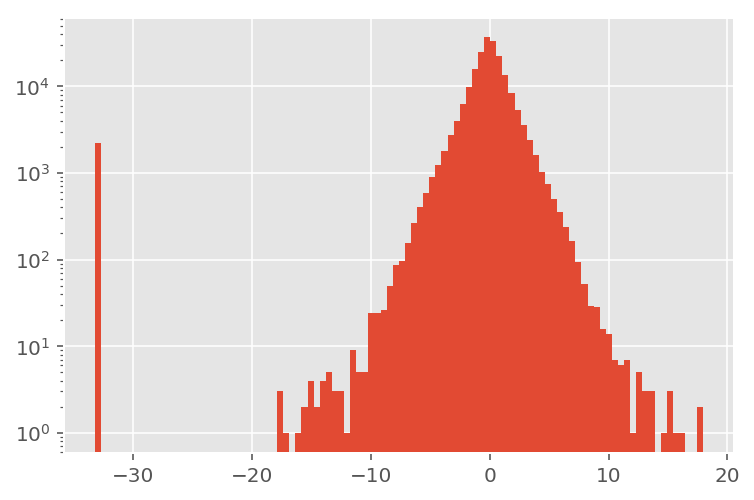

In [10]:
df_train['target'].hist(bins=100, log=True);

# Load transactions

In [11]:
%%time

def load_transactions(path_to_file):
    
    df = pd.read_csv(path_to_file)
    
    # parse date features
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['purchase_year'] = df['purchase_date'].dt.year.astype('category')
    df['purchase_month'] = df['purchase_date'].dt.month.astype('category')
    df['purchase_woy'] = df['purchase_date'].dt.weekofyear.astype('category')
    df['purchase_weekend'] = (df['purchase_date'].dt.weekday >= 5).astype(int)
    
    # factorize binary features
    df['authorized_flag'] = df['authorized_flag'].map({'Y': 1, 'N': 0})
    df['category_1'] = df['category_1'].map({'Y': 1, 'N': 0})

    # fill missing values
    # <smart> imputing didn't work well 
    df['category_2'].fillna(6.0, inplace=True)
    df['category_3'].fillna('A', inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)
    df['installments'] = df['installments'].replace({-1: 0, 999: 13})
    
    # transformation
    df['purchase_amount'] = np.round((df['purchase_amount'] + 0.7469078) / 0.0015, 2)
    
    # add reference_date for additional features and zeros failed trans
    df = df.merge(reference_date[['card_id', 'reference_date']], on='card_id', how='left')
    df.loc[df['authorized_flag'] == 0, 'purchase_amount'] = 0
    
    df['month_diff'] = ((df['reference_date'] - df['purchase_date']).dt.days) // 30 + df['month_lag']
    df['month_diff_feb'] = ((np.datetime64('2018-02-01') - df['purchase_date']).dt.days) // 30 + df['month_lag']
    
    df['amount_month_ratio'] = df['purchase_amount'] / (df['month_diff_feb'] + 1)
    df['price'] = df['purchase_amount'] / (df['installments'] + 1)
    
    return df

old_trans = load_transactions('all/historical_transactions.csv')
new_trans = load_transactions('all/new_merchant_transactions.csv')

CPU times: user 4min 2s, sys: 1min 8s, total: 5min 11s
Wall time: 5min 24s


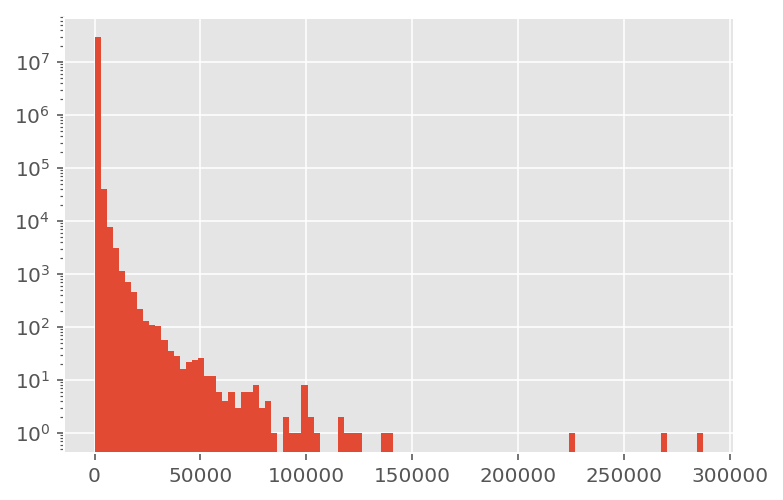

In [12]:
old_trans['purchase_amount'].hist(bins=100, log=True, figsize=(6,4));

# Aggregate transactions

In [23]:
%%time
def old_trans_agg(history): 
    
    aggs = {}
    
    for col in ['purchase_year', 'purchase_month', 'purchase_woy', 'purchase_weekend', 
                'subsector_id', 'merchant_id', 'merchant_category_id']:
        aggs[col] = ['nunique']
    
    aggs['purchase_amount'] = ['sum', 'max', 'min', 'median', 'std']
    aggs['amount_month_ratio'] = ['sum', 'max', 'min', 'median', 'std']
    aggs['price'] = ['sum', 'max', 'min', 'median', 'std']
    aggs['installments'] = ['sum', 'max', 'min', 'median', 'std']
    aggs['purchase_date'] = ['max', 'min']
    aggs['month_diff'] = ['mean', 'max', 'min']
    aggs['month_diff_feb'] = ['mean', 'max', 'min']
    aggs['month_lag'] = ['min', 'max', 'mean']
    aggs['authorized_flag'] = ['sum', 'mean']
    aggs['purchase_weekend'] = ['sum', 'mean']
    aggs['category_1'] = ['sum', 'mean']
    aggs['card_id'] = ['size']
    aggs['reference_date'] = ['max']
    
    agg_trans = history.groupby('card_id').agg(aggs)
    agg_trans.columns = ['agg_' + k + '_' + str(agg) for k in aggs.keys() for agg in aggs[k]]
    agg_trans.reset_index(drop=False, inplace=True)
    
    agg_trans['agg_purchase_date_diff'] = (agg_trans['agg_purchase_date_max'] - agg_trans['agg_purchase_date_min']).dt.days
    agg_trans['agg_purchase_date_average'] = agg_trans['agg_purchase_date_diff'] / agg_trans['agg_card_id_size']
    agg_trans['agg_purchase_date_uptonow_min'] = (agg_trans['agg_reference_date_max'] - agg_trans['agg_purchase_date_min']).dt.days
    agg_trans['agg_purchase_date_uptonow_max'] = (agg_trans['agg_reference_date_max'] - agg_trans['agg_purchase_date_max']).dt.days
    
    agg_trans.columns = 'old_' + agg_trans.columns
    agg_trans = agg_trans.rename(columns={'old_card_id': 'card_id'})
    
    return agg_trans

old_trans_agg = old_trans_agg(old_trans)

print('save to csv file ...')
old_trans_agg.to_csv('old_trans_agg.csv')

save to csv file ...
CPU times: user 3min 41s, sys: 27.4 s, total: 4min 8s
Wall time: 4min 13s


In [24]:
%%time
def new_trans_agg(history): 

    aggs = {}
    
    for col in ['purchase_year', 'purchase_month', 'purchase_woy', 'purchase_weekend', 
                'subsector_id', 'merchant_id', 'merchant_category_id']:
        aggs[col] = ['nunique']
        
    aggs['purchase_amount'] = ['sum', 'max', 'min', 'median', 'std']
    aggs['amount_month_ratio'] = ['sum', 'max', 'min', 'median', 'std']
    aggs['price'] = ['sum', 'max', 'min', 'median', 'std']
    aggs['installments'] = ['sum', 'max', 'min', 'median', 'std']
    aggs['purchase_date'] = ['max', 'min']
    aggs['month_diff'] = ['mean', 'max', 'min']
    aggs['month_diff_feb'] = ['mean', 'max', 'min']
    aggs['month_lag'] = ['min', 'max', 'mean']
    aggs['purchase_weekend'] = ['sum', 'mean']
    aggs['category_1'] = ['sum', 'mean']
    aggs['card_id'] = ['size']
    aggs['reference_date'] = ['max']
    
    agg_trans = history.groupby('card_id').agg(aggs)
    agg_trans.columns = ['agg_' + k + '_' + str(agg) for k in aggs.keys() for agg in aggs[k]]
    agg_trans.reset_index(drop=False, inplace=True)
    
    agg_trans['agg_purchase_date_diff'] = (agg_trans['agg_purchase_date_max'] - agg_trans['agg_purchase_date_min']).dt.days
    agg_trans['agg_purchase_date_average'] = (agg_trans['agg_purchase_date_diff'] / agg_trans['agg_card_id_size'])
    agg_trans['agg_purchase_date_uptonow_min'] = (agg_trans['agg_reference_date_max'] - agg_trans['agg_purchase_date_min']).dt.days
    agg_trans['agg_purchase_date_uptonow_max'] = (agg_trans['agg_reference_date_max'] - agg_trans['agg_purchase_date_max']).dt.days
    

    agg_trans.columns = 'new_' + agg_trans.columns
    agg_trans = agg_trans.rename(columns={'new_card_id': 'card_id'})

    return agg_trans

new_trans_agg = new_trans_agg(new_trans)

print('save to csv file ...')
new_trans_agg.to_csv('new_trans_agg.csv')

save to csv file ...
CPU times: user 31.5 s, sys: 700 ms, total: 32.2 s
Wall time: 34.6 s


### Combine 

In [13]:
%%time
old_trans_agg = pd.read_csv('old_trans_agg.csv', index_col=0, 
                            parse_dates=['old_agg_purchase_date_max', 'old_agg_purchase_date_min'])
new_trans_agg = pd.read_csv('new_trans_agg.csv', index_col=0,
                            parse_dates=['new_agg_purchase_date_max', 'new_agg_purchase_date_min'])

trans_agg = old_trans_agg.merge(new_trans_agg, on='card_id', how='left')

CPU times: user 6.33 s, sys: 410 ms, total: 6.74 s
Wall time: 7.31 s


In [14]:
trans_agg['best1'] = trans_agg['old_agg_purchase_date_uptonow_max'] - trans_agg['new_agg_purchase_date_uptonow_max']
trans_agg['best2'] = trans_agg['old_agg_purchase_date_uptonow_max'] - trans_agg['new_agg_purchase_date_uptonow_min']
trans_agg['best3'] = trans_agg['old_agg_purchase_date_uptonow_min'] - trans_agg['new_agg_purchase_date_uptonow_max']
trans_agg['best4'] = trans_agg['old_agg_purchase_date_uptonow_min'] - trans_agg['new_agg_purchase_date_uptonow_min']

In [15]:
# how many new merchants visited 
trans_agg['merchant_id_rate'] = trans_agg['new_agg_merchant_id_nunique'] / trans_agg['old_agg_merchant_id_nunique']

# other features
trans_agg['agg_purchase_amount_median_rate'] = trans_agg['new_agg_purchase_amount_median'] / trans_agg['old_agg_purchase_amount_median']
trans_agg['agg_month_diff_mean_rate'] = trans_agg['new_agg_month_diff_mean'] / trans_agg['old_agg_month_diff_mean']
trans_agg['agg_purchase_woy_nunique_rate'] = trans_agg['new_agg_purchase_woy_nunique'] / trans_agg['old_agg_purchase_woy_nunique']
trans_agg['agg_purchase_month_nunique_rate'] = trans_agg['new_agg_purchase_month_nunique'] / trans_agg['old_agg_purchase_month_nunique']
trans_agg['agg_purchase_amount_sum_rate'] = trans_agg['new_agg_purchase_amount_sum'] / trans_agg['old_agg_purchase_amount_sum']
trans_agg['agg_subsector_id_nunique_rate'] = trans_agg['new_agg_subsector_id_nunique'] / trans_agg['old_agg_subsector_id_nunique']

# Load features

In [16]:
!ls saved_features_24-02/

amount_grouping.csv	new_duplicated_amounts_df.csv  old_gradients_df.csv
diff_sector_pca_df.csv	new_ex_cost_pca.csv	       old_ols_regr.csv
failed_amount_rate.csv	new_gradients_df.csv	       old_purch_pca_df.csv
failed_trans_df.csv	new_ols_regr.csv	       reference_date.csv
merch_grouping.csv	new_purch_pca_df.csv	       top_merch_cat.csv
merch_pca_df.csv	old_duplicated_amounts_df.csv  woy_purchase.csv
merch_pop.csv		old_ex_cost_pca.csv


In [18]:
%%time 

# Failed transactions
failed_trans_df = pd.read_csv('saved_features_24-02/failed_trans_df.csv', index_col=0)

# Gradients
new_gradients_df = pd.read_csv('saved_features_24-02/new_gradients_df.csv', index_col=0)
old_gradients_df = pd.read_csv('saved_features_24-02/old_gradients_df.csv', index_col=0)

# OLS regression
old_ols_regr = pd.read_csv('saved_features_24-02/old_ols_regr.csv', index_col=0)
new_ols_regr = pd.read_csv('saved_features_24-02/new_ols_regr.csv', index_col=0)

# duplicated_amounts
old_duplicated_amounts_df = pd.read_csv('saved_features_24-02/old_duplicated_amounts_df.csv', index_col=0)
new_duplicated_amounts_df = pd.read_csv('saved_features_24-02/new_duplicated_amounts_df.csv', index_col=0)

# PCA 
merch_pca_df = pd.read_csv('saved_features_24-02/merch_pca_df.csv', index_col=0)
old_purch_pca_df = pd.read_csv('saved_features_24-02/old_purch_pca_df.csv', index_col=0)
new_purch_pca_df = pd.read_csv('saved_features_24-02/new_purch_pca_df.csv', index_col=0)

# merchnts featreus
merch_grouping = pd.read_csv('saved_features_24-02/merch_grouping.csv', index_col=0)
amount_grouping = pd.read_csv('saved_features_24-02/amount_grouping.csv', index_col=0)
merch_pop = pd.read_csv('saved_features_24-02/merch_pop.csv', index_col=0)
old_ex_cost_pca = pd.read_csv('saved_features_24-02/old_ex_cost_pca.csv', index_col=0)
new_ex_cost_pca = pd.read_csv('saved_features_24-02/new_ex_cost_pca.csv', index_col=0)
diff_sector_pca_df = pd.read_csv('saved_features_24-02/diff_sector_pca_df.csv', index_col=0)

CPU times: user 11.6 s, sys: 860 ms, total: 12.5 s
Wall time: 14.6 s


# Merge

In [19]:
df_to_use = [
    
    # ADD AGG
    trans_agg,

    # Failed transactions
    failed_trans_df,
    
    # ADD GRADIENTS
    old_gradients_df, new_gradients_df,
    
    # OLS regression
    old_ols_regr, new_ols_regr,
    
    # duplicated_amounts
    old_duplicated_amounts_df, new_duplicated_amounts_df,

    # PCA decompostions of matrix cards-features
    merch_pca_df,
    old_purch_pca_df,
    new_purch_pca_df,
    merch_grouping,
    amount_grouping,
    merch_pop,
    old_ex_cost_pca,
    new_ex_cost_pca,
    diff_sector_pca_df,

    ]

In [20]:
gc.collect()

19858

In [21]:
%%time
for df in df_to_use:
    df_train = df_train.merge(df, on='card_id', how='left')
    df_test = df_test.merge(df, on='card_id', how='left')
    
gc.collect()

CPU times: user 14.3 s, sys: 2.08 s, total: 16.4 s
Wall time: 16.4 s


In [22]:
df_train['merchant_cat_popularity'].fillna(0.0, inplace=True)
df_test['merchant_cat_popularity'].fillna(0.0, inplace=True)

df_test['merchant_popularity'].fillna(0.0, inplace=True)
df_train['merchant_popularity'].fillna(0.0, inplace=True)

In [23]:
for df in [df_train, df_test]:

    df['old_hist_first_buy'] = (df['old_agg_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_agg_purchase_date_min'] - df['first_active_month']).dt.days
    df['old_hist_last_buy'] = (df['old_agg_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_hist_last_buy'] = (df['new_agg_purchase_date_max'] - df['first_active_month']).dt.days
    
    for feature in ['old_agg_purchase_date_max', 'old_agg_purchase_date_min',
                    'new_agg_purchase_date_max', 'new_agg_purchase_date_min']:
        df[feature] = df[feature].astype(np.int64) * 1e-9
    
    df['purchase_amount_sum_ratio'] = df['new_agg_purchase_amount_sum'] / df['old_agg_purchase_amount_sum']
    df['purchase_amount_median_ratio'] = df['new_agg_purchase_amount_median'] / df['old_agg_purchase_amount_median']
    df['purchase_amount_max_ratio'] = df['new_agg_purchase_amount_max'] / df['old_agg_purchase_amount_max']
    df['card_id_size_ratio'] = df['new_agg_card_id_size'] / df['old_agg_card_id_size']

    df['new_CLV'] = df['new_agg_card_id_size'] * df['new_agg_purchase_amount_sum'] / df['new_agg_month_diff_mean']
    df['old_CLV'] = df['old_agg_card_id_size'] * df['old_agg_purchase_amount_sum'] / df['old_agg_month_diff_mean']

# Custom target stratification among folds 

In [24]:
def custom_shuffle(df_train, i_seed):
    
    print('custom_shuffle...')
    
    df_train['rounded_target'] = df_train['target'].round(0)
    df_train = df_train.sort_values(by='rounded_target').reset_index(drop=True)

    vc = df_train['rounded_target'].value_counts()
    vc = dict(sorted(vc.items()))

    df = pd.DataFrame()
    df_train['indexcol'] = 0
    i = 0
    for k, v in vc.items():
        step = len(df_train) / v
        indent = len(df_train) / (v + 1)
        df2 = df_train[df_train['rounded_target'] == k].sample(v, random_state=i_seed).reset_index(drop=True)
        if k == -33:
            df2 = df2.sort_values(by='card_id', ascending=False)
            for j in range(0, v):
                df2.at[j, 'indexcol'] = indent + j*step + 0.000001*i
            df = pd.concat([df2, df])
        if k != -33:
            df2 = df2.sort_values(by='card_id', ascending=True)
            for j in range(0, v):
                df2.at[j, 'indexcol'] = indent + j*step + 0.000001*i
            df = pd.concat([df2, df])
        i += 1

    df_train = df.sort_values('indexcol', ascending=True).reset_index(drop=True)
    
    del df_train['indexcol'], df_train['rounded_target'], vc
    gc.collect()
    
    return df_train

custom_shuffle...


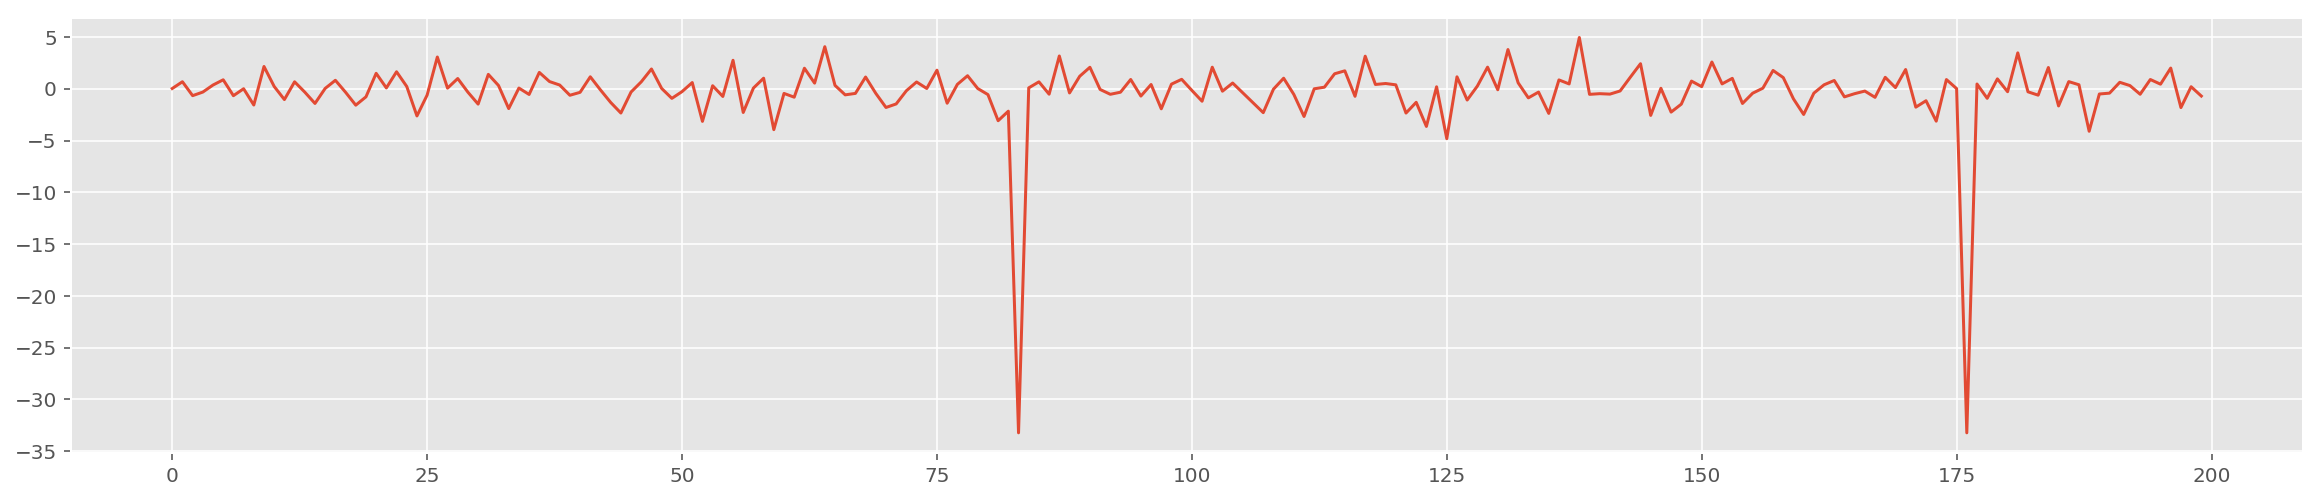

In [27]:
df_train_example1 =  custom_shuffle(df_train, i_seed=42)

plt.figure(figsize=(20,4))
plt.plot(df_train_example1.index[:200], df_train_example1['target'][:200]);

custom_shuffle...


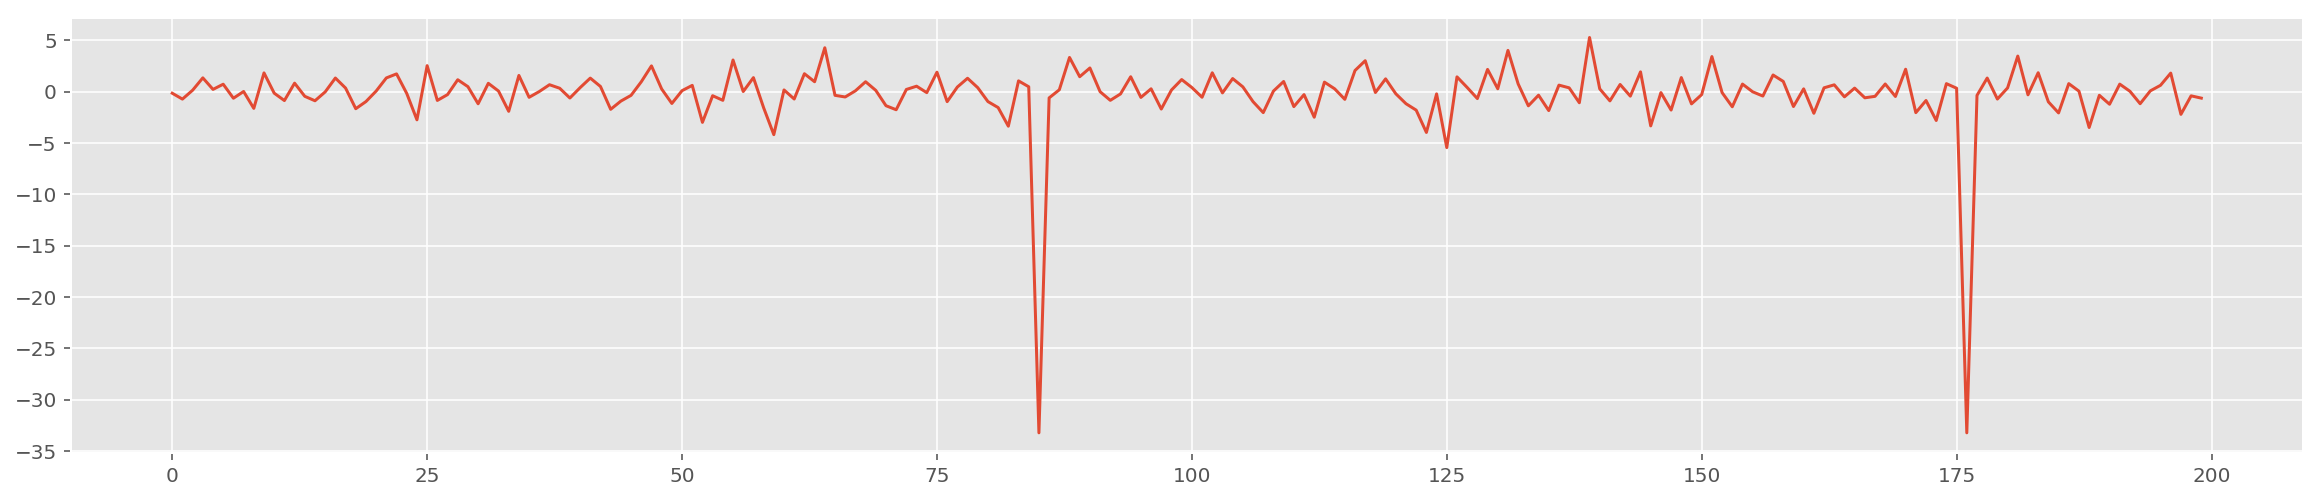

In [28]:
df_train_example2 =  custom_shuffle(df_train, i_seed=77142)

plt.figure(figsize=(20,4))
plt.plot(df_train_example2.index[:200], df_train_example2['target'][:200]);

# Feature selection!

We gonna use target purmutation technique

https://www.kaggle.com/ogrellier/feature-selection-with-null-importances/notebook

https://www.kaggle.com/dansbecker/permutation-importance

In [26]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in [
        'card_id', 'first_active_month', 'target', 'outliers', 
        'agg_reference_date_max', 'reference_date', 'old_agg_reference_date_max', 'new_agg_reference_date_max',
        'rounded_target', 'indexcol',
    ]]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['target'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['target'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    
    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting': 'gbdt',
        'num_leaves': 64,
        'max_depth': 7,
        'learning_rate': 0.008,
        'min_child_samples': 32,
        "reg_alpha": 0.3, 
        "reg_lambda": 0.1,
        "bagging_fraction" : 0.8, 
        'feature_fraction': 0.8,
        'bagging_freq': 1,
        'bagging_seed': 0,
        'verbosity': -1,
        'n_jobs': 11,
    }

    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=1000)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = np.sqrt(mean_squared_error(y, clf.predict(data[train_features])))
    
    return imp_df

In [27]:
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=df_train, shuffle=False)

In [28]:
actual_imp_df.sort_values(by='importance_gain', ascending=False).head(10)

feature  importance_gain  importance_split  \
7                     reference_woy     3.664895e+06              5904   
47      old_agg_month_diff_feb_mean     2.671335e+06               605   
3                  start_year_month     2.646358e+06              4739   
55           old_agg_category_1_sum     2.374938e+06              1164   
216        merch_amount_rate_by_lag     1.548129e+06               913   
44          old_agg_month_diff_mean     1.423154e+06               884   
15   old_agg_purchase_month_nunique     1.142102e+06               631   
175            old_pca_merch_cnt_12     9.330755e+05               850   
56          old_agg_category_1_mean     8.616227e+05               608   
37         old_agg_installments_sum     7.521050e+05               714   

     trn_score  
7     3.272168  
47    3.272168  
3     3.272168  
55    3.272168  
216   3.272168  
44    3.272168  
15    3.272168  
175   3.272168  
56    3.272168  
37    3.272168

In [29]:
null_imp_df = pd.DataFrame()
nb_runs = 50

import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=df_train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)
    
    gc.collect()

Done with   50 of   50 (Spent  49.9 min)

In [32]:
null_imp_df.head(10)

feature  importance_gain  importance_split  trn_score  run
0         feature_1     12689.681625                54   3.707452    1
1         feature_2      3745.024166                20   3.707452    1
2         feature_3      2465.243780                 7   3.707452    1
3  start_year_month    905590.106665              4118   3.707452    1
4    start_year_woy    162760.334692               714   3.707452    1
5    reference_year       117.164001                 1   3.707452    1
6   reference_month     11125.062374                59   3.707452    1
7     reference_woy    929806.963011              4101   3.707452    1
8      elapsed_time     17181.429283                79   3.707452    1
9  elapsed_time_feb      5995.227180                25   3.707452    1

In [33]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(20, 4))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances', color='b', bins=50)
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=1, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances', color='b', bins=50)
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=1, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())
    
    plt.show()

In [46]:
for i in range(0, 5):
    print(i, actual_imp_df.sort_values(by=['importance_gain', 'importance_split'])['feature'].values[i])

    display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, 
                          feature_=actual_imp_df.sort_values(by=['importance_gain', 'importance_split'])['feature'].values[i])

NameError: name 'actual_imp_df' is not defined

# Prepare to learning

In [40]:
df_train_columns = [c for c in df_train.columns if c not in [
    
    # not used 
    'card_id', 'first_active_month', 'target', 
    'outliers',
    'agg_reference_date_max', 'reference_date', 'old_agg_reference_date_max', 'new_agg_reference_date_max',
    'start_year_month', 'start_year_woy', 'rounded_target',

    # bad split & gain importances
    'new_agg_month_lag_max',
    'new_agg_purchase_date_uptonow_max',
    'new_diff_auth_mean_avg',
    'new_diff_auth_mean_wavg',
    'feature_3_target_enc',
    'new_agg_purchase_year_nunique',
    'new_diff_purchase_sum_wavg',
    'old_agg_price_min',
    'new_agg_card_id_size',
    'new_agg_purchase_woy_nunique',
    'old_agg_purchase_amount_min',
    'old_agg_amount_month_ratio_min',
    'new_duplicated_amount_rate',
    'new_diff_purchase_mean_wavg',
    'new_agg_purchase_weekend_sum',
    'failed_gap_min',
    'new_diff_auth_sum_wavg',
    'new_diff_purchase_count_avg',
    'new_agg_purchase_weekend_mean',
    'pca_purch_cnt_5_y',
    'new_diff_purchase_sum_avg',
    'pca_purch_cnt_6_y',
    'pca_purch_cnt_4_y',
    'new_regr_r2',
    'new_regr_stderr',
    'old_regr_pred_to_refe_tr',
    'new_diff_purchase_mean_avg',
    'pca_purch_cnt_8_y',
    'new_pca_merch_cnt_6',
    'pca_purch_cnt_7_y',
    'pca_purch_cnt_3_y',
    'new_pca_merch_cnt_5',
    'new_pca_merch_cnt_7',
    'new_pca_merch_cnt_10',
    'new_pca_merch_cnt_4',
    'new_pca_merch_cnt_13',
    'new_pca_merch_cnt_15',
    'new_pca_merch_cnt_8',
    'new_pca_merch_cnt_3',
    'new_pca_merch_cnt_9',
    'purc_cat4_y',
    'merchant_cat_popularity',
    'new_pca_merch_cnt_2',
    'new_pca_merch_cnt_14',
    
    
]]

In [41]:
big_features = df_train_columns

In [42]:
from scipy.stats import ks_2samp

list_p_value = []

for i in tqdm_notebook(df_train_columns):
    list_p_value.append(ks_2samp(df_test[i] , df_train[i])[1])

Se = pd.Series(list_p_value, index = df_train_columns).sort_values() 
list_discarded = list(Se[Se < .05].index)

In [43]:
list_discarded

['feature_1_target_enc',
 'feature_2_target_enc',
 'pca_purch_cnt_10_y',
 'pca_purch_cnt_1_y',
 'sector_diff2',
 'merch_cnt_mean_rate_by_lag',
 'pca_purch_cnt_1_x']

In [44]:
big_features = [f for f in big_features if f not in list_discarded]

In [47]:
len(big_features)

205

# ~~ MODEL PIPELINE ~~


# Part 1. Classification

custom_shuffle...
fold 0
Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.0486787	valid_1's binary_logloss: 0.0505334
[100]	training's binary_logloss: 0.0445681	valid_1's binary_logloss: 0.047392
[150]	training's binary_logloss: 0.0420253	valid_1's binary_logloss: 0.0457817
[200]	training's binary_logloss: 0.0402282	valid_1's binary_logloss: 0.0448273
[250]	training's binary_logloss: 0.038784	valid_1's binary_logloss: 0.0442319
[300]	training's binary_logloss: 0.0375441	valid_1's binary_logloss: 0.0438691
[350]	training's binary_logloss: 0.0365117	valid_1's binary_logloss: 0.0436279
[400]	training's binary_logloss: 0.0356387	valid_1's binary_logloss: 0.0434485
[450]	training's binary_logloss: 0.0348828	valid_1's binary_logloss: 0.0433749
[500]	training's binary_logloss: 0.0342009	valid_1's binary_logloss: 0.0433056
[550]	training's binary_logloss: 0.0335884	valid_1's binary_logloss: 0.04326
[600]	training's binary_logloss: 0.0329952	valid

[300]	training's binary_logloss: 0.0371751	valid_1's binary_logloss: 0.0451257
[350]	training's binary_logloss: 0.0361155	valid_1's binary_logloss: 0.0449195
[400]	training's binary_logloss: 0.0352249	valid_1's binary_logloss: 0.0448152
[450]	training's binary_logloss: 0.0344801	valid_1's binary_logloss: 0.0447372
[500]	training's binary_logloss: 0.0337861	valid_1's binary_logloss: 0.0446634
[550]	training's binary_logloss: 0.0330912	valid_1's binary_logloss: 0.0446278
[600]	training's binary_logloss: 0.0324411	valid_1's binary_logloss: 0.0446273
[650]	training's binary_logloss: 0.0317216	valid_1's binary_logloss: 0.0446165
[700]	training's binary_logloss: 0.0310541	valid_1's binary_logloss: 0.0446095
[750]	training's binary_logloss: 0.0303767	valid_1's binary_logloss: 0.0445928
[800]	training's binary_logloss: 0.0297508	valid_1's binary_logloss: 0.0446079
[850]	training's binary_logloss: 0.029164	valid_1's binary_logloss: 0.0446132
Early stopping, best iteration is:
[779]	training's b

[50]	training's binary_logloss: 0.0486143	valid_1's binary_logloss: 0.050201
[100]	training's binary_logloss: 0.0444807	valid_1's binary_logloss: 0.0469961
[150]	training's binary_logloss: 0.0420025	valid_1's binary_logloss: 0.0453622
[200]	training's binary_logloss: 0.0402183	valid_1's binary_logloss: 0.0444328
[250]	training's binary_logloss: 0.0388126	valid_1's binary_logloss: 0.0438649
[300]	training's binary_logloss: 0.0376254	valid_1's binary_logloss: 0.0434774
[350]	training's binary_logloss: 0.0366108	valid_1's binary_logloss: 0.0432511
[400]	training's binary_logloss: 0.0357514	valid_1's binary_logloss: 0.0430825
[450]	training's binary_logloss: 0.0349583	valid_1's binary_logloss: 0.0429927
[500]	training's binary_logloss: 0.0342747	valid_1's binary_logloss: 0.0429177
[550]	training's binary_logloss: 0.0336158	valid_1's binary_logloss: 0.0428718
[600]	training's binary_logloss: 0.0329772	valid_1's binary_logloss: 0.0428621
[650]	training's binary_logloss: 0.032343	valid_1's bi

Early stopping, best iteration is:
[691]	training's binary_logloss: 0.0320769	valid_1's binary_logloss: 0.0430673
fold 3
Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.0487114	valid_1's binary_logloss: 0.0502185
[100]	training's binary_logloss: 0.0446842	valid_1's binary_logloss: 0.0469779
[150]	training's binary_logloss: 0.0422872	valid_1's binary_logloss: 0.0451858
[200]	training's binary_logloss: 0.0405041	valid_1's binary_logloss: 0.0441412
[250]	training's binary_logloss: 0.0390971	valid_1's binary_logloss: 0.0435102
[300]	training's binary_logloss: 0.0379161	valid_1's binary_logloss: 0.0430592
[350]	training's binary_logloss: 0.0369091	valid_1's binary_logloss: 0.0427743
[400]	training's binary_logloss: 0.0360533	valid_1's binary_logloss: 0.0425783
[450]	training's binary_logloss: 0.0352921	valid_1's binary_logloss: 0.0424323
[500]	training's binary_logloss: 0.0346214	valid_1's binary_logloss: 0.0423193
[550]	training's binary_log

[250]	training's binary_logloss: 0.0388079	valid_1's binary_logloss: 0.0462184
[300]	training's binary_logloss: 0.0376447	valid_1's binary_logloss: 0.0459496
[350]	training's binary_logloss: 0.0366613	valid_1's binary_logloss: 0.0457934
[400]	training's binary_logloss: 0.035807	valid_1's binary_logloss: 0.0457092
[450]	training's binary_logloss: 0.0350956	valid_1's binary_logloss: 0.0456414
[500]	training's binary_logloss: 0.0344365	valid_1's binary_logloss: 0.0455953
[550]	training's binary_logloss: 0.0337777	valid_1's binary_logloss: 0.0455532
[600]	training's binary_logloss: 0.0332188	valid_1's binary_logloss: 0.0455232
[650]	training's binary_logloss: 0.0326125	valid_1's binary_logloss: 0.0455672
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.0332511	valid_1's binary_logloss: 0.0455213
fold 9
Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.0487191	valid_1's binary_logloss: 0.0508754
[100]	training's binary_logl

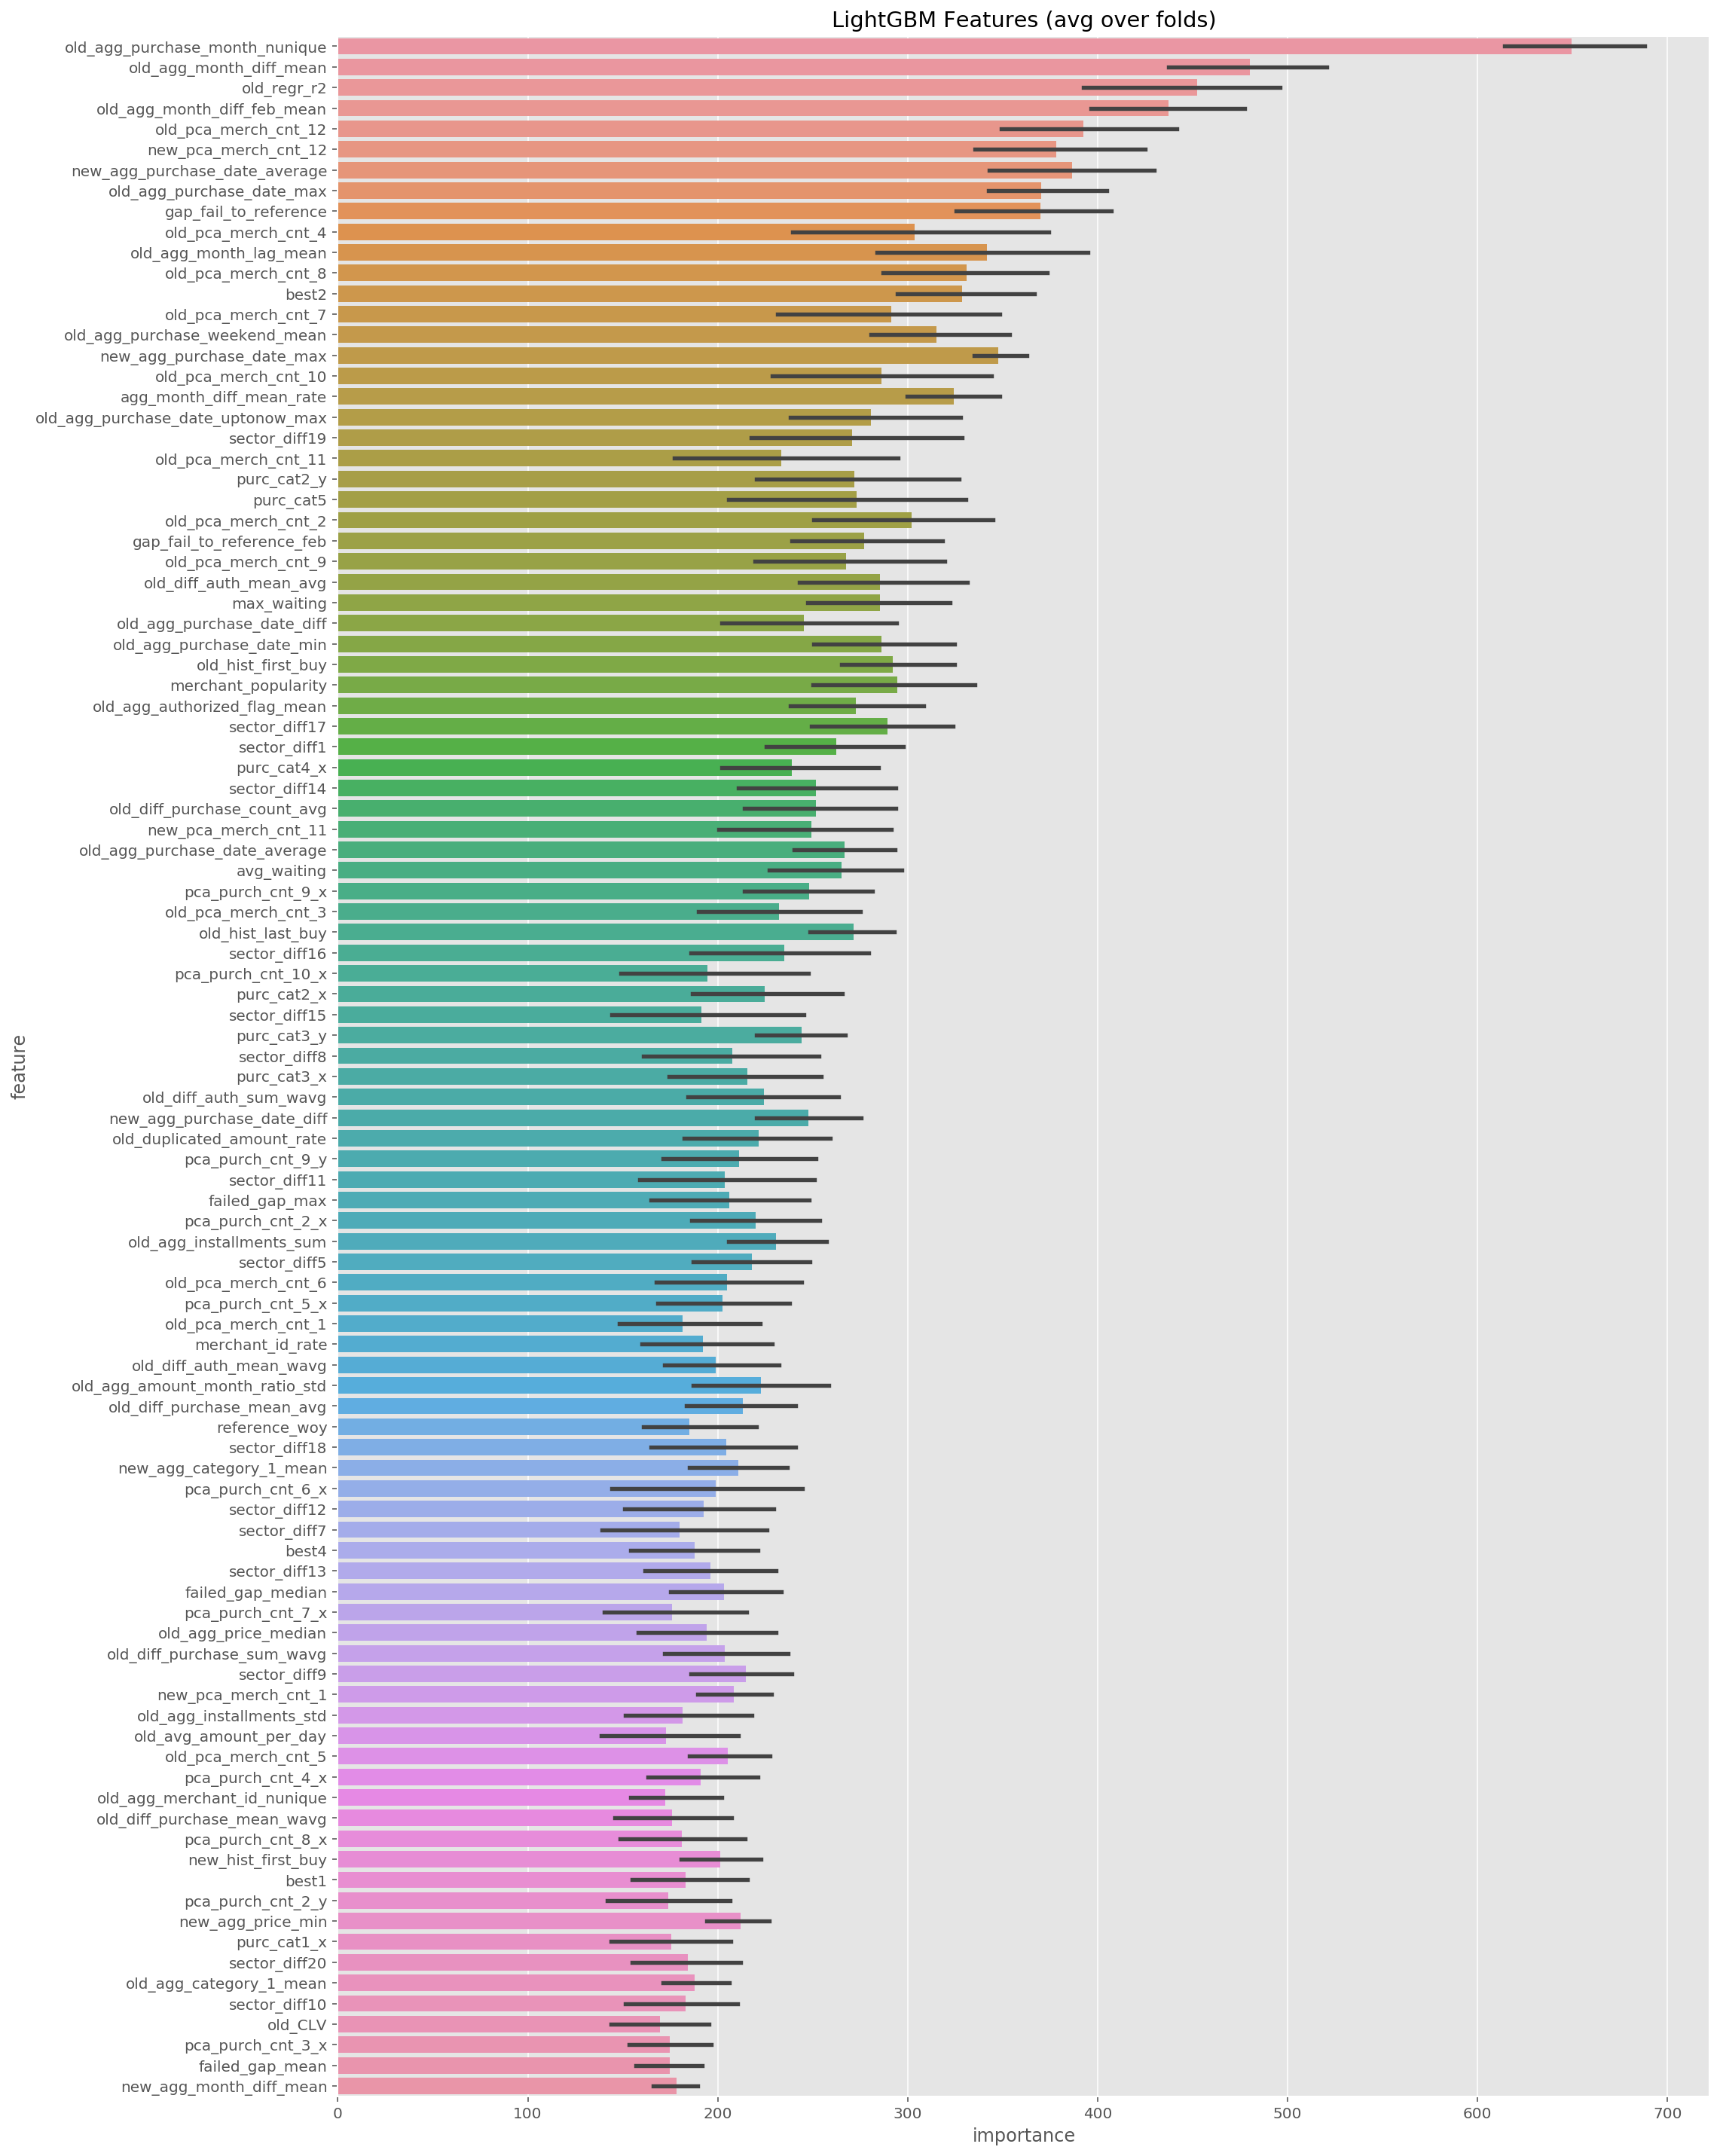

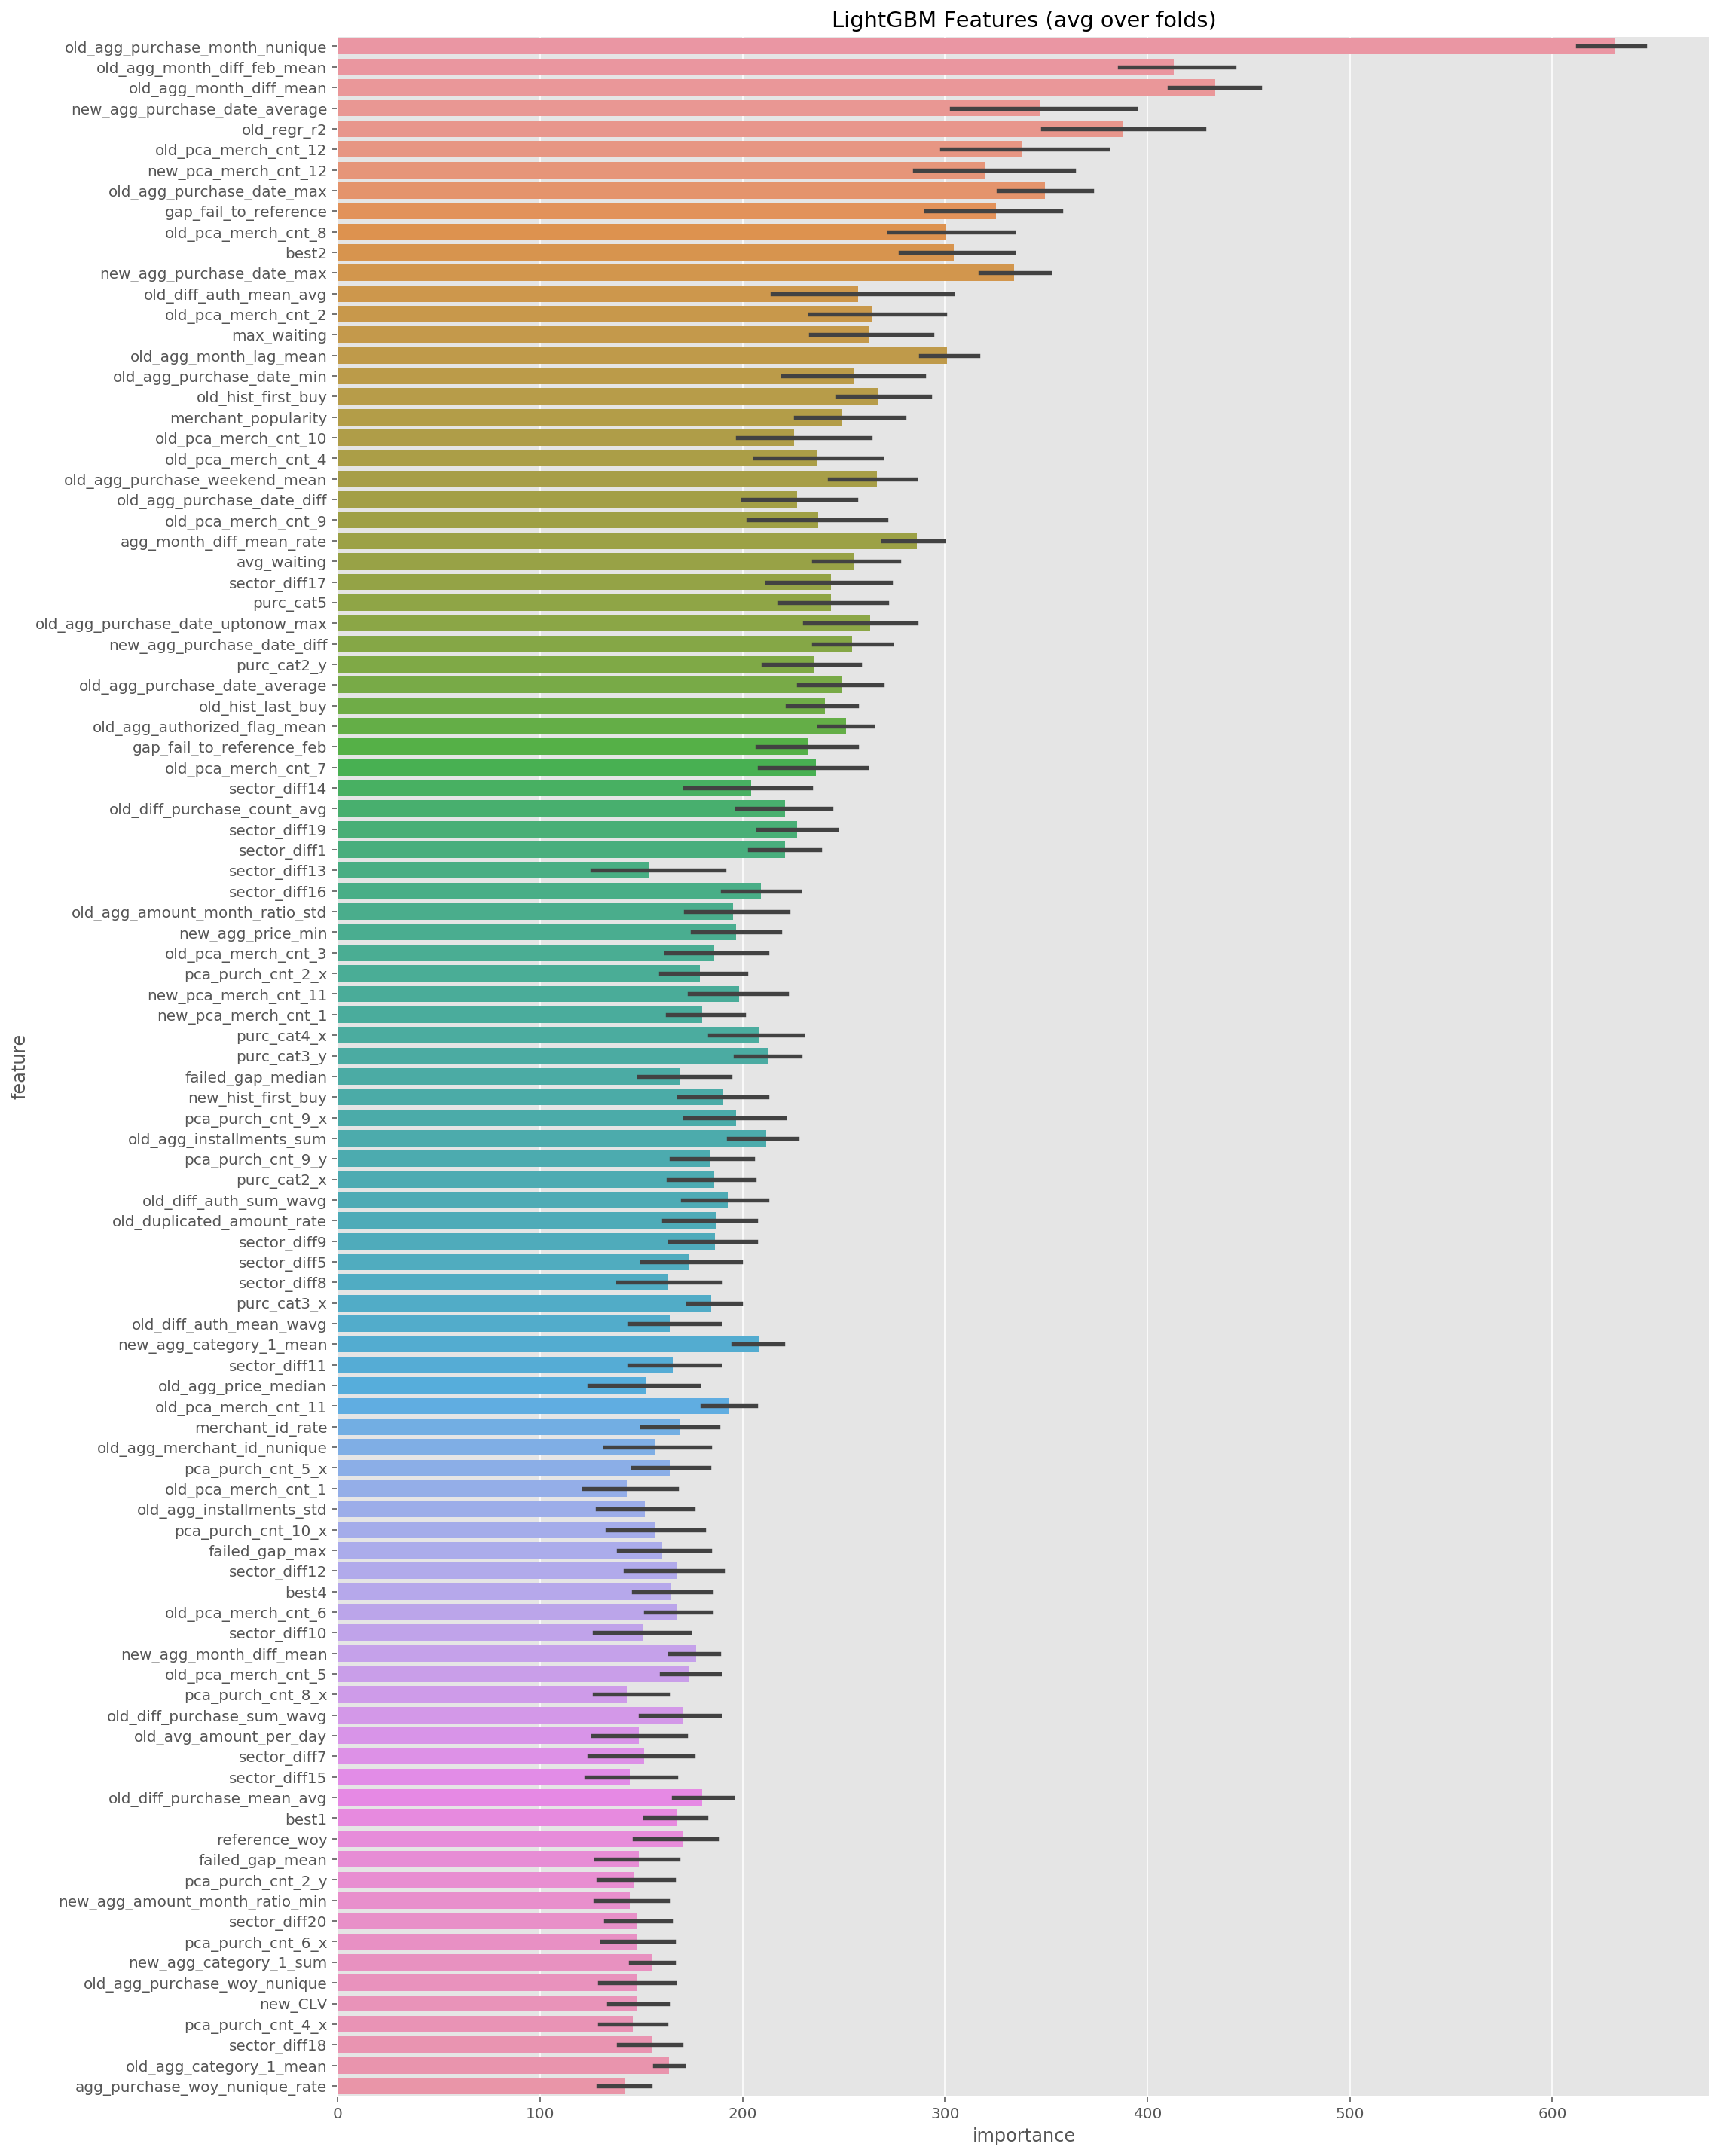

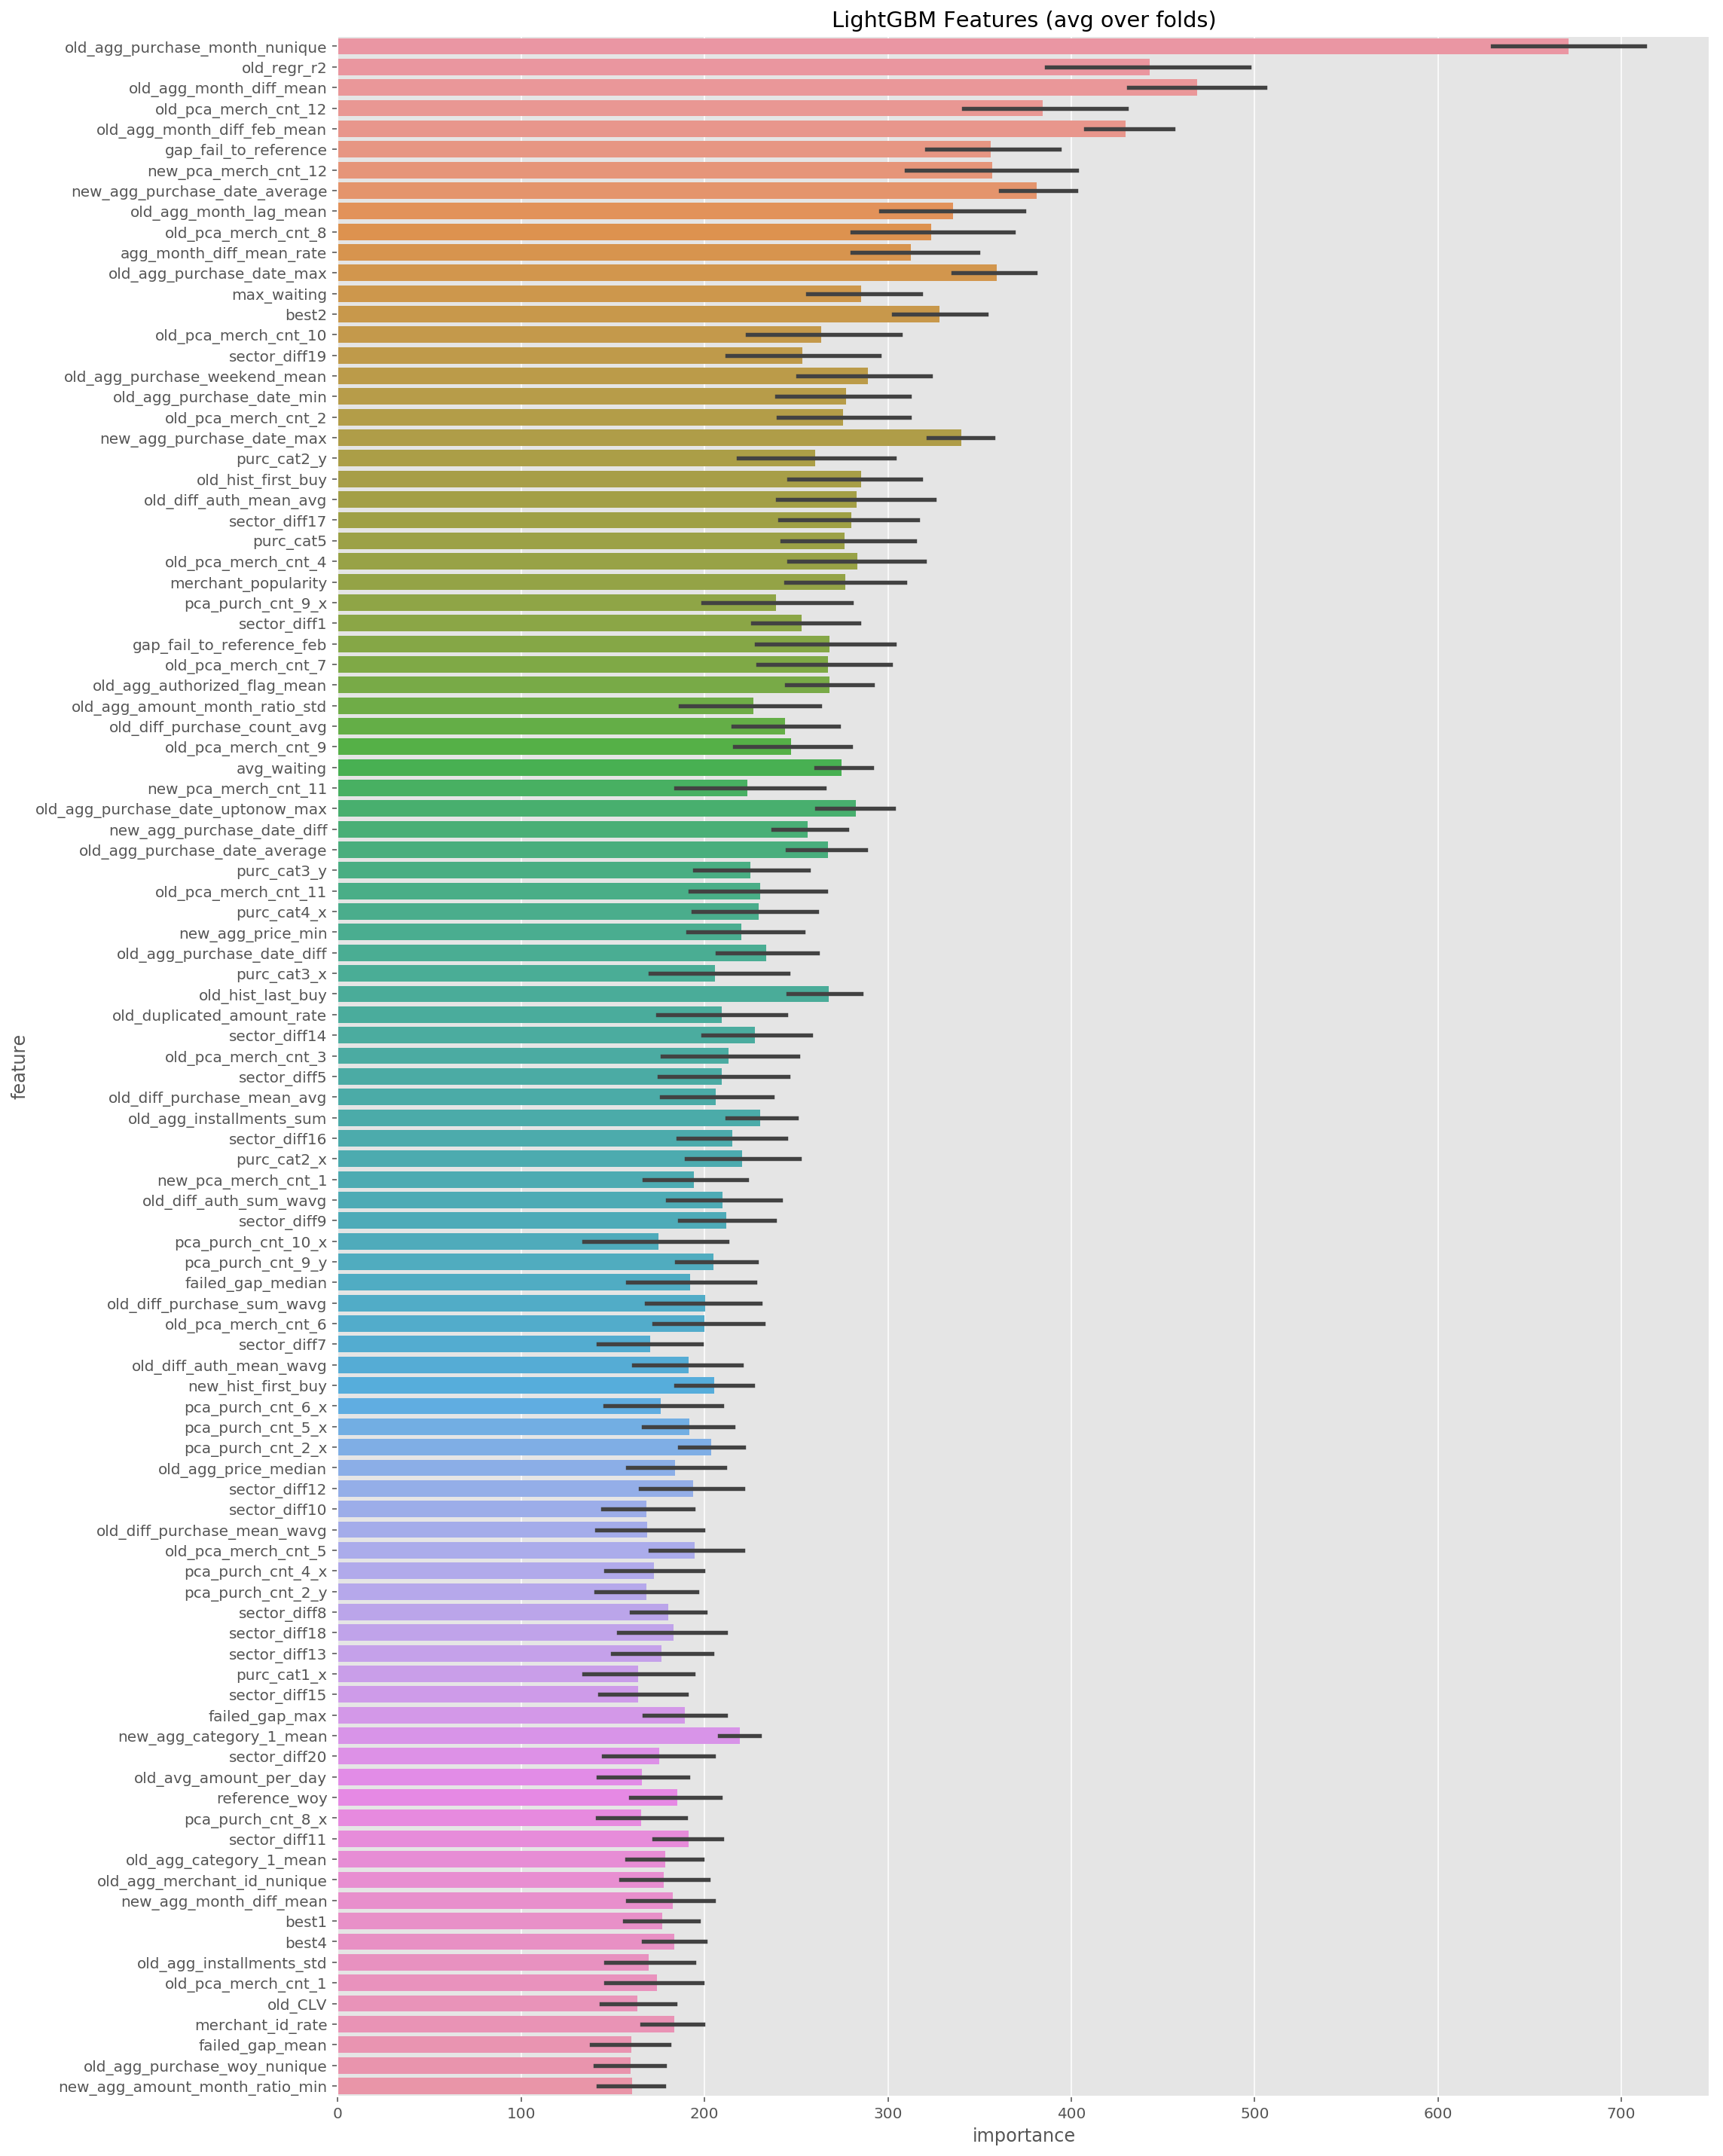

In [58]:
%%time

lgb_params = {
    'num_leaves': 64,
    'min_data_in_leaf': 50, 
    'objective':'binary',
    'max_depth': 6,
    'learning_rate': 0.007, 
    "boosting": 'gbdt',
    'feature_fraction': 0.8,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'bagging_seed': 0,
    'metric': 'binary_logloss',
    'lambda_l1': 0.3,
    'verbosity': -1,
    'random_state': 0
}


# probability of outliers for test
outlier_prob = pd.DataFrame({'card_id': df_test['card_id'].values})

# probability of outliers for train (OOF)
outlier_prob_oof = np.zeros(len(df_train))

splits = [6, 8, 10]
bad_seeds = [0, 42, 2019]

for bad_seed, n_splits in zip(bad_seeds, splits):
    
    # custom shuffle strategy
    shuffle_train = custom_shuffle(df_train=df_train, i_seed=bad_seed)
    
    # define train/test with selected features
    train_X = shuffle_train[big_features]
    train_y = shuffle_train['outliers']
    test_X = df_test[big_features]
    
    # define prediction variables as zero vector
    prediction_tr = np.zeros(len(train_X))
    prediction_te = np.zeros(len(test_X))
    
    # feature importances df for all folds
    FI_df = pd.DataFrame()
    
    # KFold with custom shuffle
    folds = KFold(n_splits=n_splits, shuffle=False, random_state=bad_seed)
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X.values)):
        print('fold', fold_)

        trn_data = lgb.Dataset(train_X.iloc[trn_idx].values, label=train_y.iloc[trn_idx].values)
        val_data = lgb.Dataset(train_X.iloc[val_idx].values, label=train_y.iloc[val_idx].values)

        clf = lgb.train(
            params=lgb_params, 
            train_set=trn_data, 
            num_boost_round=1000, 
            valid_sets=[trn_data, val_data], 
            verbose_eval=50, 
            early_stopping_rounds=100
        )
        
        prediction_tr[val_idx] = clf.predict(train_X.iloc[val_idx].values, num_iteration=clf.best_iteration)
        prediction_te += clf.predict(test_X.values, num_iteration=clf.best_iteration)
        
        # feature importances
        fold_FI_df = pd.DataFrame()
        fold_FI_df['feature'] = list(train_X.columns)
        fold_FI_df['importance'] = clf.feature_importance()
        fold_FI_df['fold'] = fold_ + 1
        FI_df = pd.concat([FI_df, fold_FI_df], axis=0)
    
    prediction_te /= n_splits

    val_score = log_loss(train_y, prediction_tr)
    print(f'SCORE: {val_score}')
    
    cols = FI_df[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:100].index
    best_features_lgb = FI_df.loc[FI_df['feature'].isin(cols)].sort_values(by='importance', ascending=False)

    plt.figure(figsize=(16,20))
    sns.barplot(x='importance', y='feature', data=best_features_lgb)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    
    # predictions for test
    col_name = 'target_seed_' + str(bad_seed)
    outlier_prob[col_name] = prediction_te
    
    # predictions for train
    outlier_prob_oof += prediction_tr
    
    gc.collect()

# average OOF prediction among all seeds
outlier_prob_oof /= len(bad_seeds)

In [64]:
df_outlier_prob = pd.DataFrame({"card_id": df_test["card_id"].values})
df_outlier_prob["target"] = outlier_prob.iloc[:, 1:].mean(axis=1)
df_outlier_prob.head()

card_id    target
0  C_ID_0ab67a22ab  0.042236
1  C_ID_130fd0cbdd  0.001254
2  C_ID_b709037bc5  0.011685
3  C_ID_d27d835a9f  0.000220
4  C_ID_2b5e3df5c2  0.001697

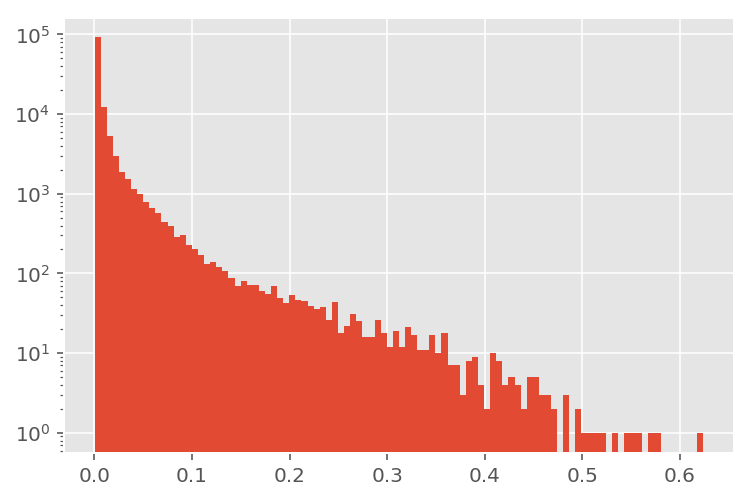

In [65]:
df_outlier_prob['target'].hist(log=True, bins=100);

# Let's find optimal threshold (not rly)

In [104]:
%%time

lgb_params = {
    'num_leaves': 100,
    'min_data_in_leaf': 50, 
    'objective':'binary',
    'max_depth': 6,
    'learning_rate': 0.005, 
    "boosting": 'gbdt',
    'feature_fraction': 0.8,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'bagging_seed': 0,
    'metric': 'binary_logloss',
    'lambda_l1': 0.3,
    'verbosity': -1,
    'random_state': 0
}

tr_hist = []
va_hist = []

# KFold with custom shuffle
folds = KFold(n_splits=5, shuffle=False, random_state=0)

# custom shuffle strategy
shuffle_train = custom_shuffle(df_train=df_train, i_seed=0)

# define train/test with selected features
train_X = shuffle_train[big_features]
train_y = shuffle_train['outliers']

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X.values)):
    print('fold', fold_)

    trn_data = lgb.Dataset(train_X.iloc[trn_idx].values, label=train_y.iloc[trn_idx].values)
    val_data = lgb.Dataset(train_X.iloc[val_idx].values, label=train_y.iloc[val_idx].values)

    clf = lgb.train(
        params=lgb_params, 
        train_set=trn_data, 
        num_boost_round=1000, 
        valid_sets=[trn_data, val_data], 
        verbose_eval=50, 
        early_stopping_rounds=100
    )
    
    prediction_tr = clf.predict(train_X.iloc[trn_idx].values, num_iteration=clf.best_iteration)
    prediction_va = clf.predict(train_X.iloc[val_idx].values, num_iteration=clf.best_iteration)
    
    tr_hist.append((prediction_tr, train_y.iloc[trn_idx].values))
    va_hist.append((prediction_va, train_y.iloc[val_idx].values))
    
gc.collect()

custom_shuffle...
fold 0
Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.0504059	valid_1's binary_logloss: 0.0522229
[100]	training's binary_logloss: 0.0464885	valid_1's binary_logloss: 0.049138
[150]	training's binary_logloss: 0.0440167	valid_1's binary_logloss: 0.0473408
[200]	training's binary_logloss: 0.0422215	valid_1's binary_logloss: 0.0461733
[250]	training's binary_logloss: 0.040822	valid_1's binary_logloss: 0.0453638
[300]	training's binary_logloss: 0.0396217	valid_1's binary_logloss: 0.044798
[350]	training's binary_logloss: 0.0386157	valid_1's binary_logloss: 0.0443964
[400]	training's binary_logloss: 0.0377096	valid_1's binary_logloss: 0.0441208
[450]	training's binary_logloss: 0.0368737	valid_1's binary_logloss: 0.0439218
[500]	training's binary_logloss: 0.0361731	valid_1's binary_logloss: 0.0437607
[550]	training's binary_logloss: 0.0355607	valid_1's binary_logloss: 0.043633
[600]	training's binary_logloss: 0.0349921	valid

[700]	training's binary_logloss: 0.0334813	valid_1's binary_logloss: 0.0444565
[750]	training's binary_logloss: 0.0329489	valid_1's binary_logloss: 0.0444468
[800]	training's binary_logloss: 0.0324627	valid_1's binary_logloss: 0.0444355
[850]	training's binary_logloss: 0.0320004	valid_1's binary_logloss: 0.0444184
[900]	training's binary_logloss: 0.0315436	valid_1's binary_logloss: 0.044408
[950]	training's binary_logloss: 0.0310255	valid_1's binary_logloss: 0.0443954
[1000]	training's binary_logloss: 0.0305474	valid_1's binary_logloss: 0.0443878
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0305474	valid_1's binary_logloss: 0.0443878
CPU times: user 20min 39s, sys: 18.3 s, total: 20min 58s
Wall time: 4min 33s


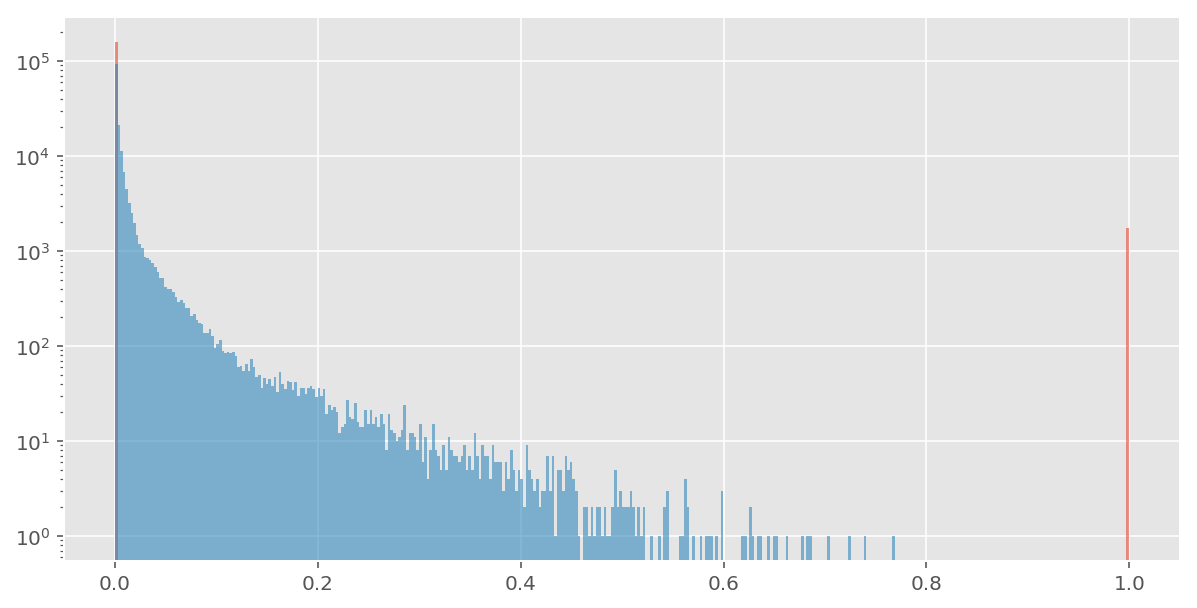

In [106]:
fold = 0

plt.figure(figsize=(10,5))
plt.hist(tr_hist[fold][1], alpha=0.6, log=True, bins=300);
plt.hist(tr_hist[fold][0], alpha=0.6, log=True, bins=300);

In [145]:
thr_quant = []
for fold in range(len(tr_hist)):
    fold_thr_quant = np.quantile(tr_hist[fold][0][tr_hist[fold][1] == 1], 0.05)
    print(fold_thr_quant)
    thr_quant.append(fold_thr_quant)

thr_quant = np.mean(thr_quant)
thr_quant

0.027482981731182028
0.02879240050362977
0.02930854554650199
0.03087359533351544
0.03182877703599339


0.02965726003016452

In [146]:
(df_outlier_prob['target'] > thr_quant).sum()

10096

In [128]:
from sklearn.metrics import f1_score, fbeta_score, confusion_matrix

delta_grid = np.linspace(0.0, 1.0, 100)

avg_cost_tr_list = []
avg_cost_va_list = []

for delta in delta_grid:
    
    tr_costs = []
    va_costs = []
    
    for p, y in tr_hist:
        # target
        t = (p > delta).astype(int)
        # cost func
#         tn, fp, fn, tp = confusion_matrix(y_true=y, y_pred=t).ravel()
#         cost = 2*tp / (2*tp + 0.01*fp + fn)
        cost = fbeta_score(y_true=y, y_pred=t, beta=0.05)
        tr_costs.append(cost)
        
    for p, y in va_hist:
        # target
        t = (p > delta).astype(int)
        # cost func
#         tn, fp, fn, tp = confusion_matrix(y_true=y, y_pred=t).ravel()
#         cost = 2*tp / (2*tp + 0.01*fp + fn)
        cost = fbeta_score(y_true=y, y_pred=t, beta=0.05)
        va_costs.append(cost)
        
    avg_cost_tr = np.mean(tr_costs)
    avg_cost_va = np.mean(va_costs)
    
    avg_cost_tr_list.append(avg_cost_tr)
    avg_cost_va_list.append(avg_cost_va)

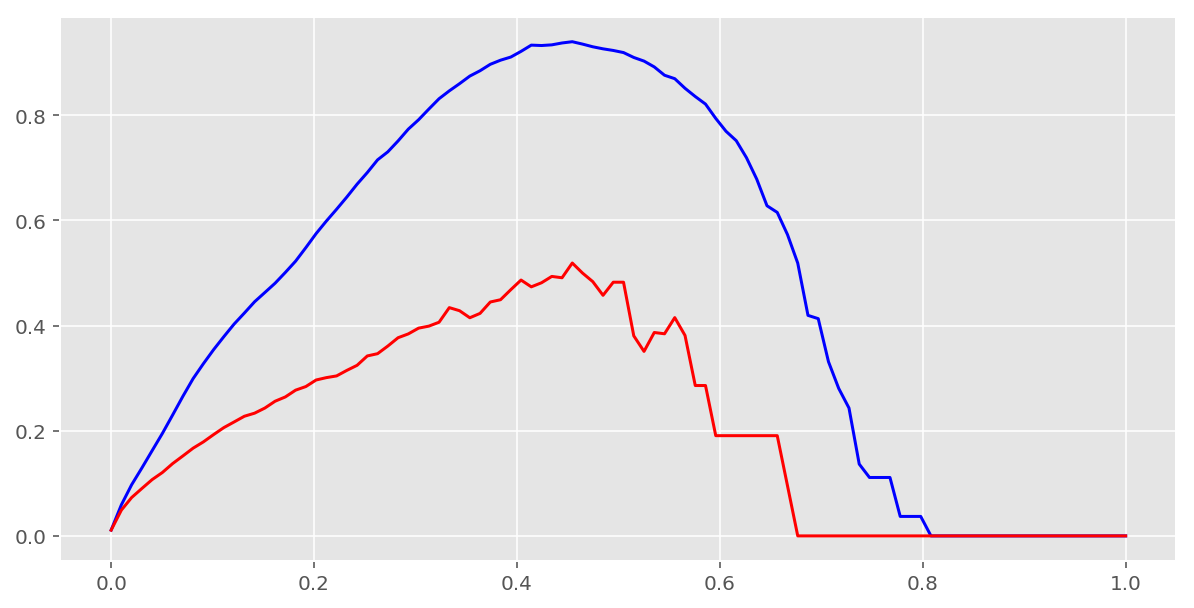

In [129]:
plt.figure(figsize=(10,5))
plt.plot(delta_grid, avg_cost_tr_list, color='b');
plt.plot(delta_grid, avg_cost_va_list, color='r');

In [138]:
thr_optima = delta_grid[np.argmax(avg_cost_va_list)]
(df_outlier_prob['target'] > thr_optima).sum()

24

# Part 2. Forecast without -33

In [262]:
# df_train['oof_prob'] = outlier_prob_oof
# df_test['oof_prob'] = outlier_prob.iloc[:, 1:].mean(axis=1)

custom_shuffle...
fold 0
Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 1.63863	valid_1's rmse: 1.63138
[100]	training's rmse: 1.59435	valid_1's rmse: 1.59295
[150]	training's rmse: 1.56861	valid_1's rmse: 1.5729
[200]	training's rmse: 1.55222	valid_1's rmse: 1.56209
[250]	training's rmse: 1.54081	valid_1's rmse: 1.55574
[300]	training's rmse: 1.53239	valid_1's rmse: 1.55197
[350]	training's rmse: 1.52549	valid_1's rmse: 1.54928
[400]	training's rmse: 1.51969	valid_1's rmse: 1.54741
[450]	training's rmse: 1.51465	valid_1's rmse: 1.54602
[500]	training's rmse: 1.51002	valid_1's rmse: 1.54492
[550]	training's rmse: 1.50607	valid_1's rmse: 1.5441
[600]	training's rmse: 1.50237	valid_1's rmse: 1.54336
[650]	training's rmse: 1.49904	valid_1's rmse: 1.54279
[700]	training's rmse: 1.49573	valid_1's rmse: 1.54235
[750]	training's rmse: 1.49264	valid_1's rmse: 1.54194
[800]	training's rmse: 1.48974	valid_1's rmse: 1.54158
[850]	training's rmse: 1.48702	vali

[450]	training's rmse: 1.51636	valid_1's rmse: 1.5392
[500]	training's rmse: 1.51194	valid_1's rmse: 1.53807
[550]	training's rmse: 1.50805	valid_1's rmse: 1.53725
[600]	training's rmse: 1.50447	valid_1's rmse: 1.5366
[650]	training's rmse: 1.50108	valid_1's rmse: 1.53608
[700]	training's rmse: 1.49792	valid_1's rmse: 1.53565
[750]	training's rmse: 1.49491	valid_1's rmse: 1.53531
[800]	training's rmse: 1.49212	valid_1's rmse: 1.53499
[850]	training's rmse: 1.48931	valid_1's rmse: 1.53472
[900]	training's rmse: 1.48666	valid_1's rmse: 1.53451
[950]	training's rmse: 1.48401	valid_1's rmse: 1.53434
[1000]	training's rmse: 1.48176	valid_1's rmse: 1.53424
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 1.48176	valid_1's rmse: 1.53424
fold 1
Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 1.63638	valid_1's rmse: 1.64666
[100]	training's rmse: 1.59252	valid_1's rmse: 1.60688
[150]	training's rmse: 1.56706	valid_1's rmse: 1.58615
[20

[1000]	training's rmse: 1.47857	valid_1's rmse: 1.5551
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 1.47857	valid_1's rmse: 1.5551
fold 7
Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 1.63605	valid_1's rmse: 1.6506
[100]	training's rmse: 1.59239	valid_1's rmse: 1.6101
[150]	training's rmse: 1.56701	valid_1's rmse: 1.58815
[200]	training's rmse: 1.55096	valid_1's rmse: 1.57571
[250]	training's rmse: 1.53966	valid_1's rmse: 1.56822
[300]	training's rmse: 1.53119	valid_1's rmse: 1.56345
[350]	training's rmse: 1.52426	valid_1's rmse: 1.56023
[400]	training's rmse: 1.51854	valid_1's rmse: 1.55802
[450]	training's rmse: 1.51358	valid_1's rmse: 1.55645
[500]	training's rmse: 1.50922	valid_1's rmse: 1.5553
[550]	training's rmse: 1.50523	valid_1's rmse: 1.55422
[600]	training's rmse: 1.50173	valid_1's rmse: 1.5535
[650]	training's rmse: 1.49844	valid_1's rmse: 1.55301
[700]	training's rmse: 1.49518	valid_1's rmse: 1.55252
[750]	t

[350]	training's rmse: 1.52608	valid_1's rmse: 1.55479
[400]	training's rmse: 1.52042	valid_1's rmse: 1.55274
[450]	training's rmse: 1.51547	valid_1's rmse: 1.55133
[500]	training's rmse: 1.51119	valid_1's rmse: 1.55021
[550]	training's rmse: 1.50722	valid_1's rmse: 1.54938
[600]	training's rmse: 1.5036	valid_1's rmse: 1.5487
[650]	training's rmse: 1.50027	valid_1's rmse: 1.54824
[700]	training's rmse: 1.49707	valid_1's rmse: 1.54772
[750]	training's rmse: 1.49415	valid_1's rmse: 1.54743
[800]	training's rmse: 1.49141	valid_1's rmse: 1.54706
[850]	training's rmse: 1.4887	valid_1's rmse: 1.54671
[900]	training's rmse: 1.48596	valid_1's rmse: 1.54642
[950]	training's rmse: 1.4834	valid_1's rmse: 1.54625
[1000]	training's rmse: 1.48093	valid_1's rmse: 1.54597
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 1.48093	valid_1's rmse: 1.54597
fold 6
Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 1.63727	valid_1's rmse: 1.63963
[100]

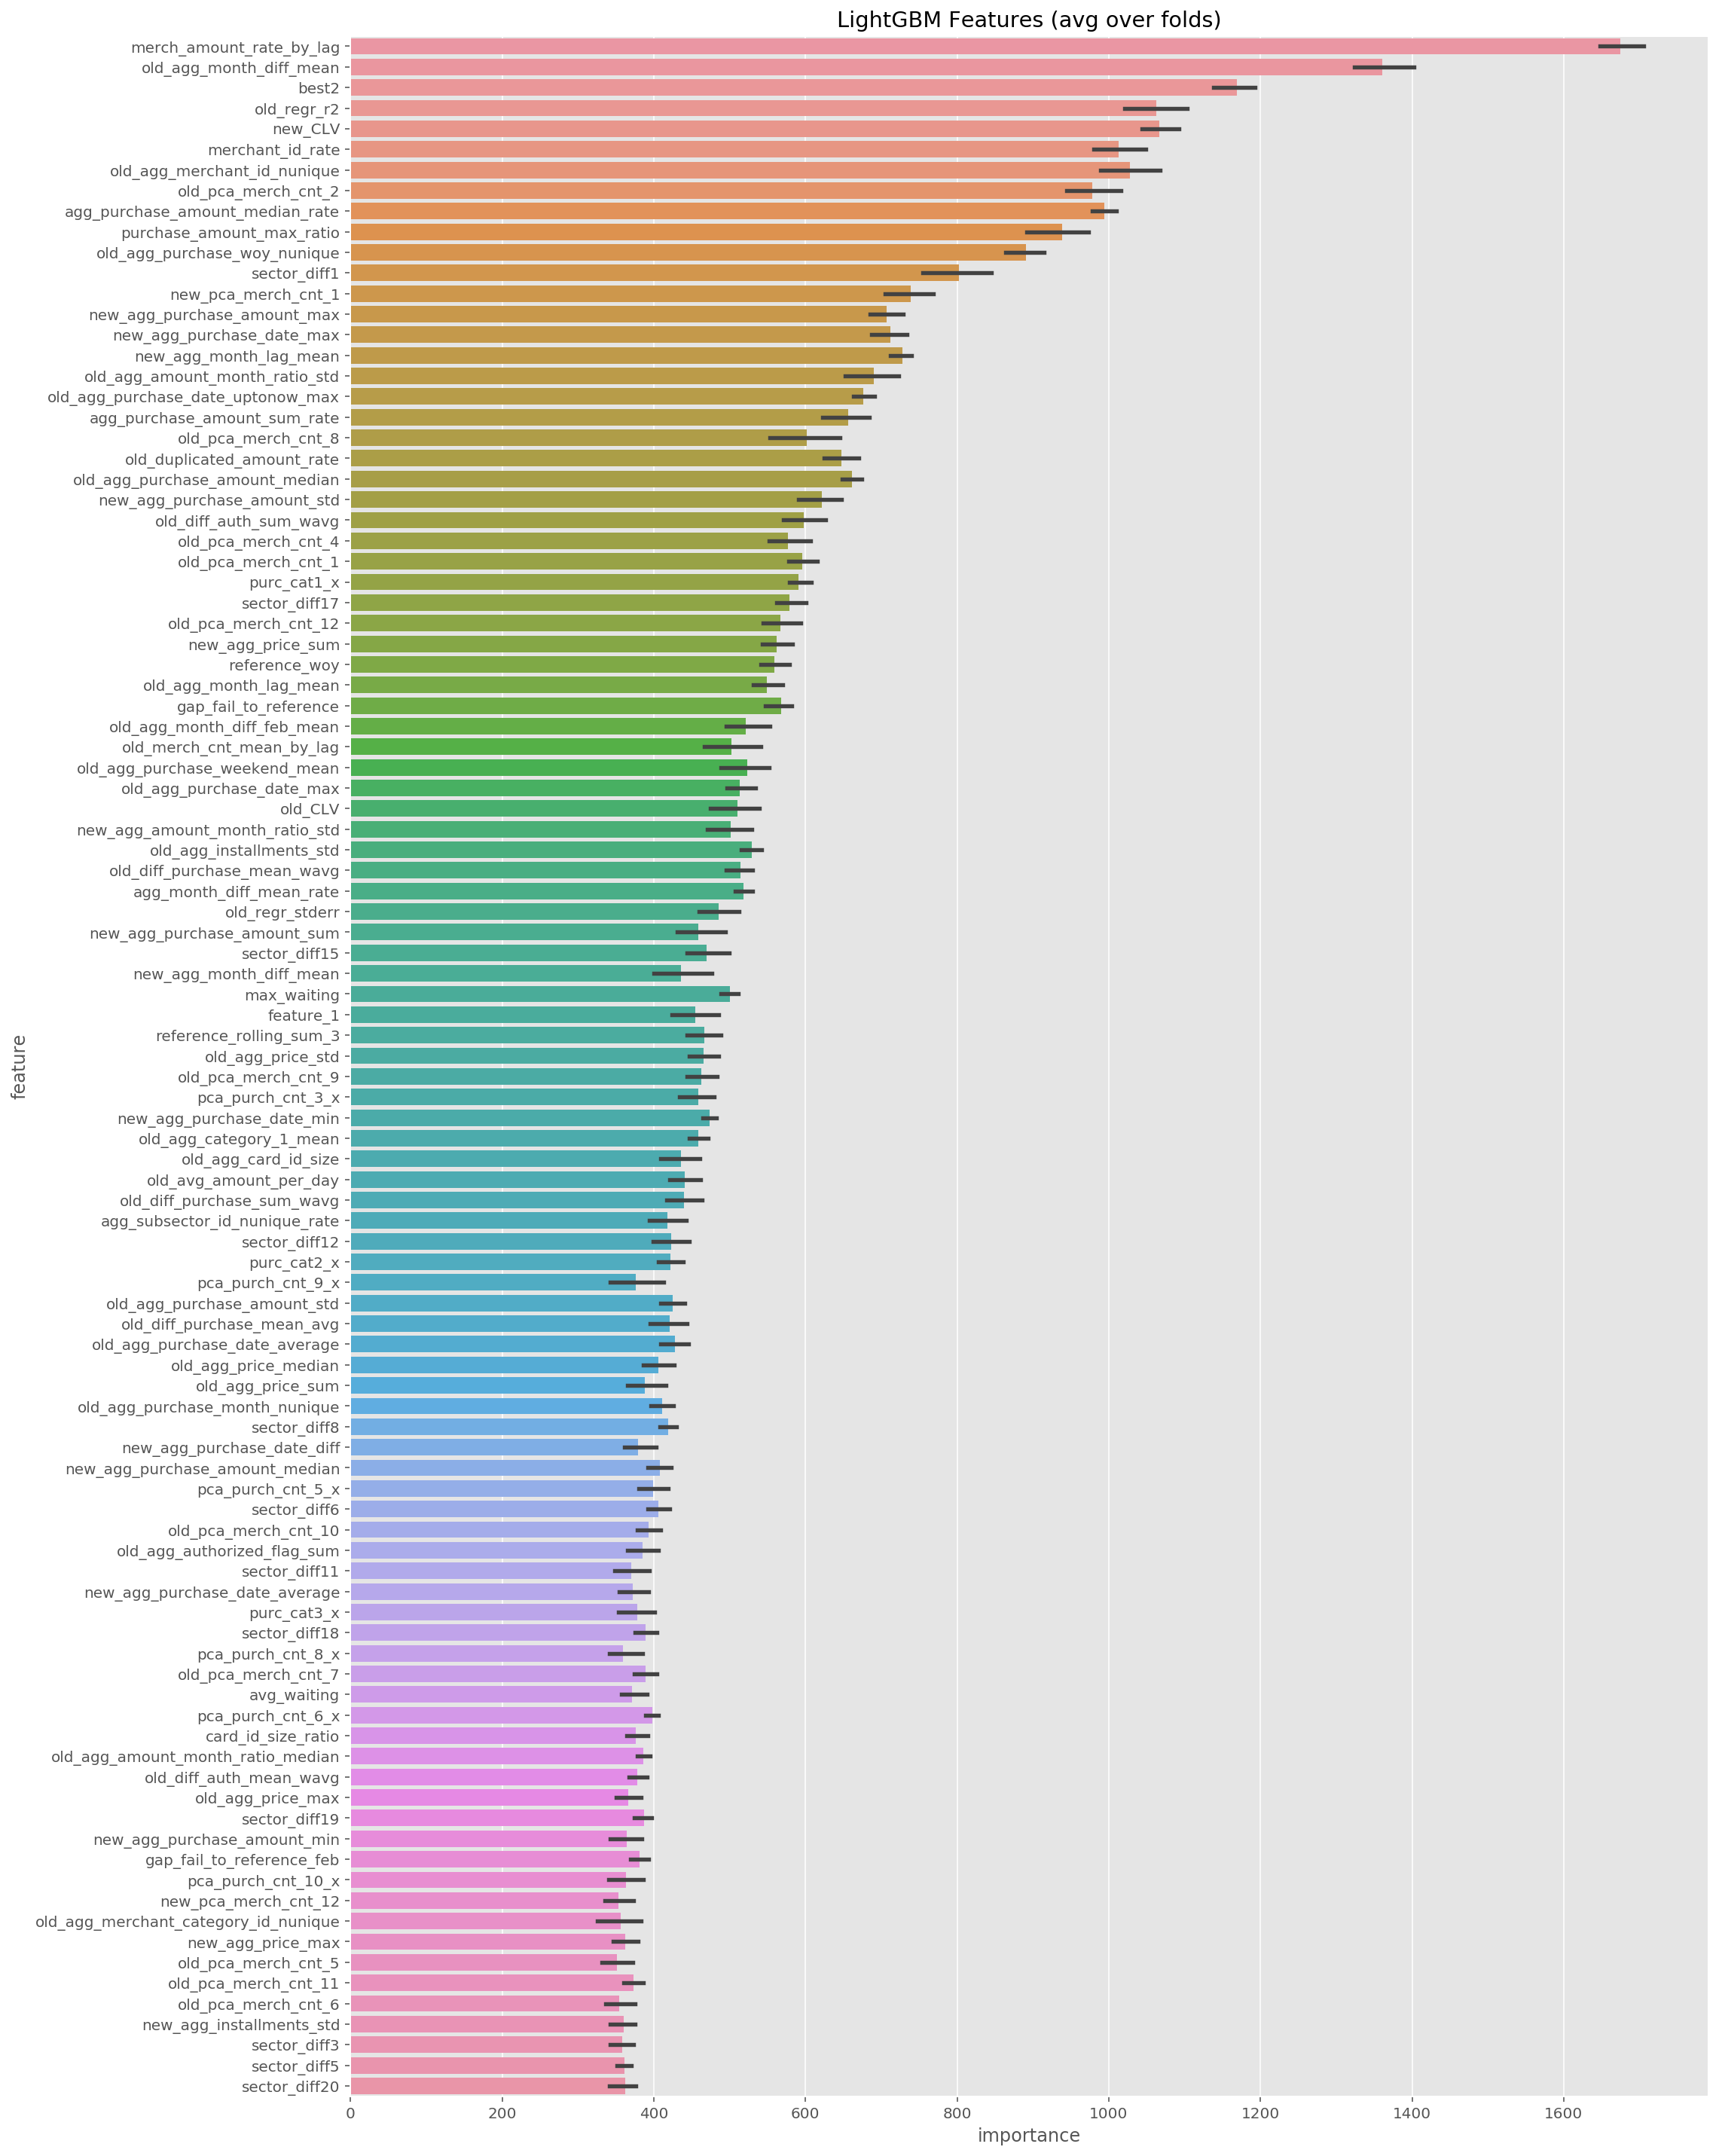

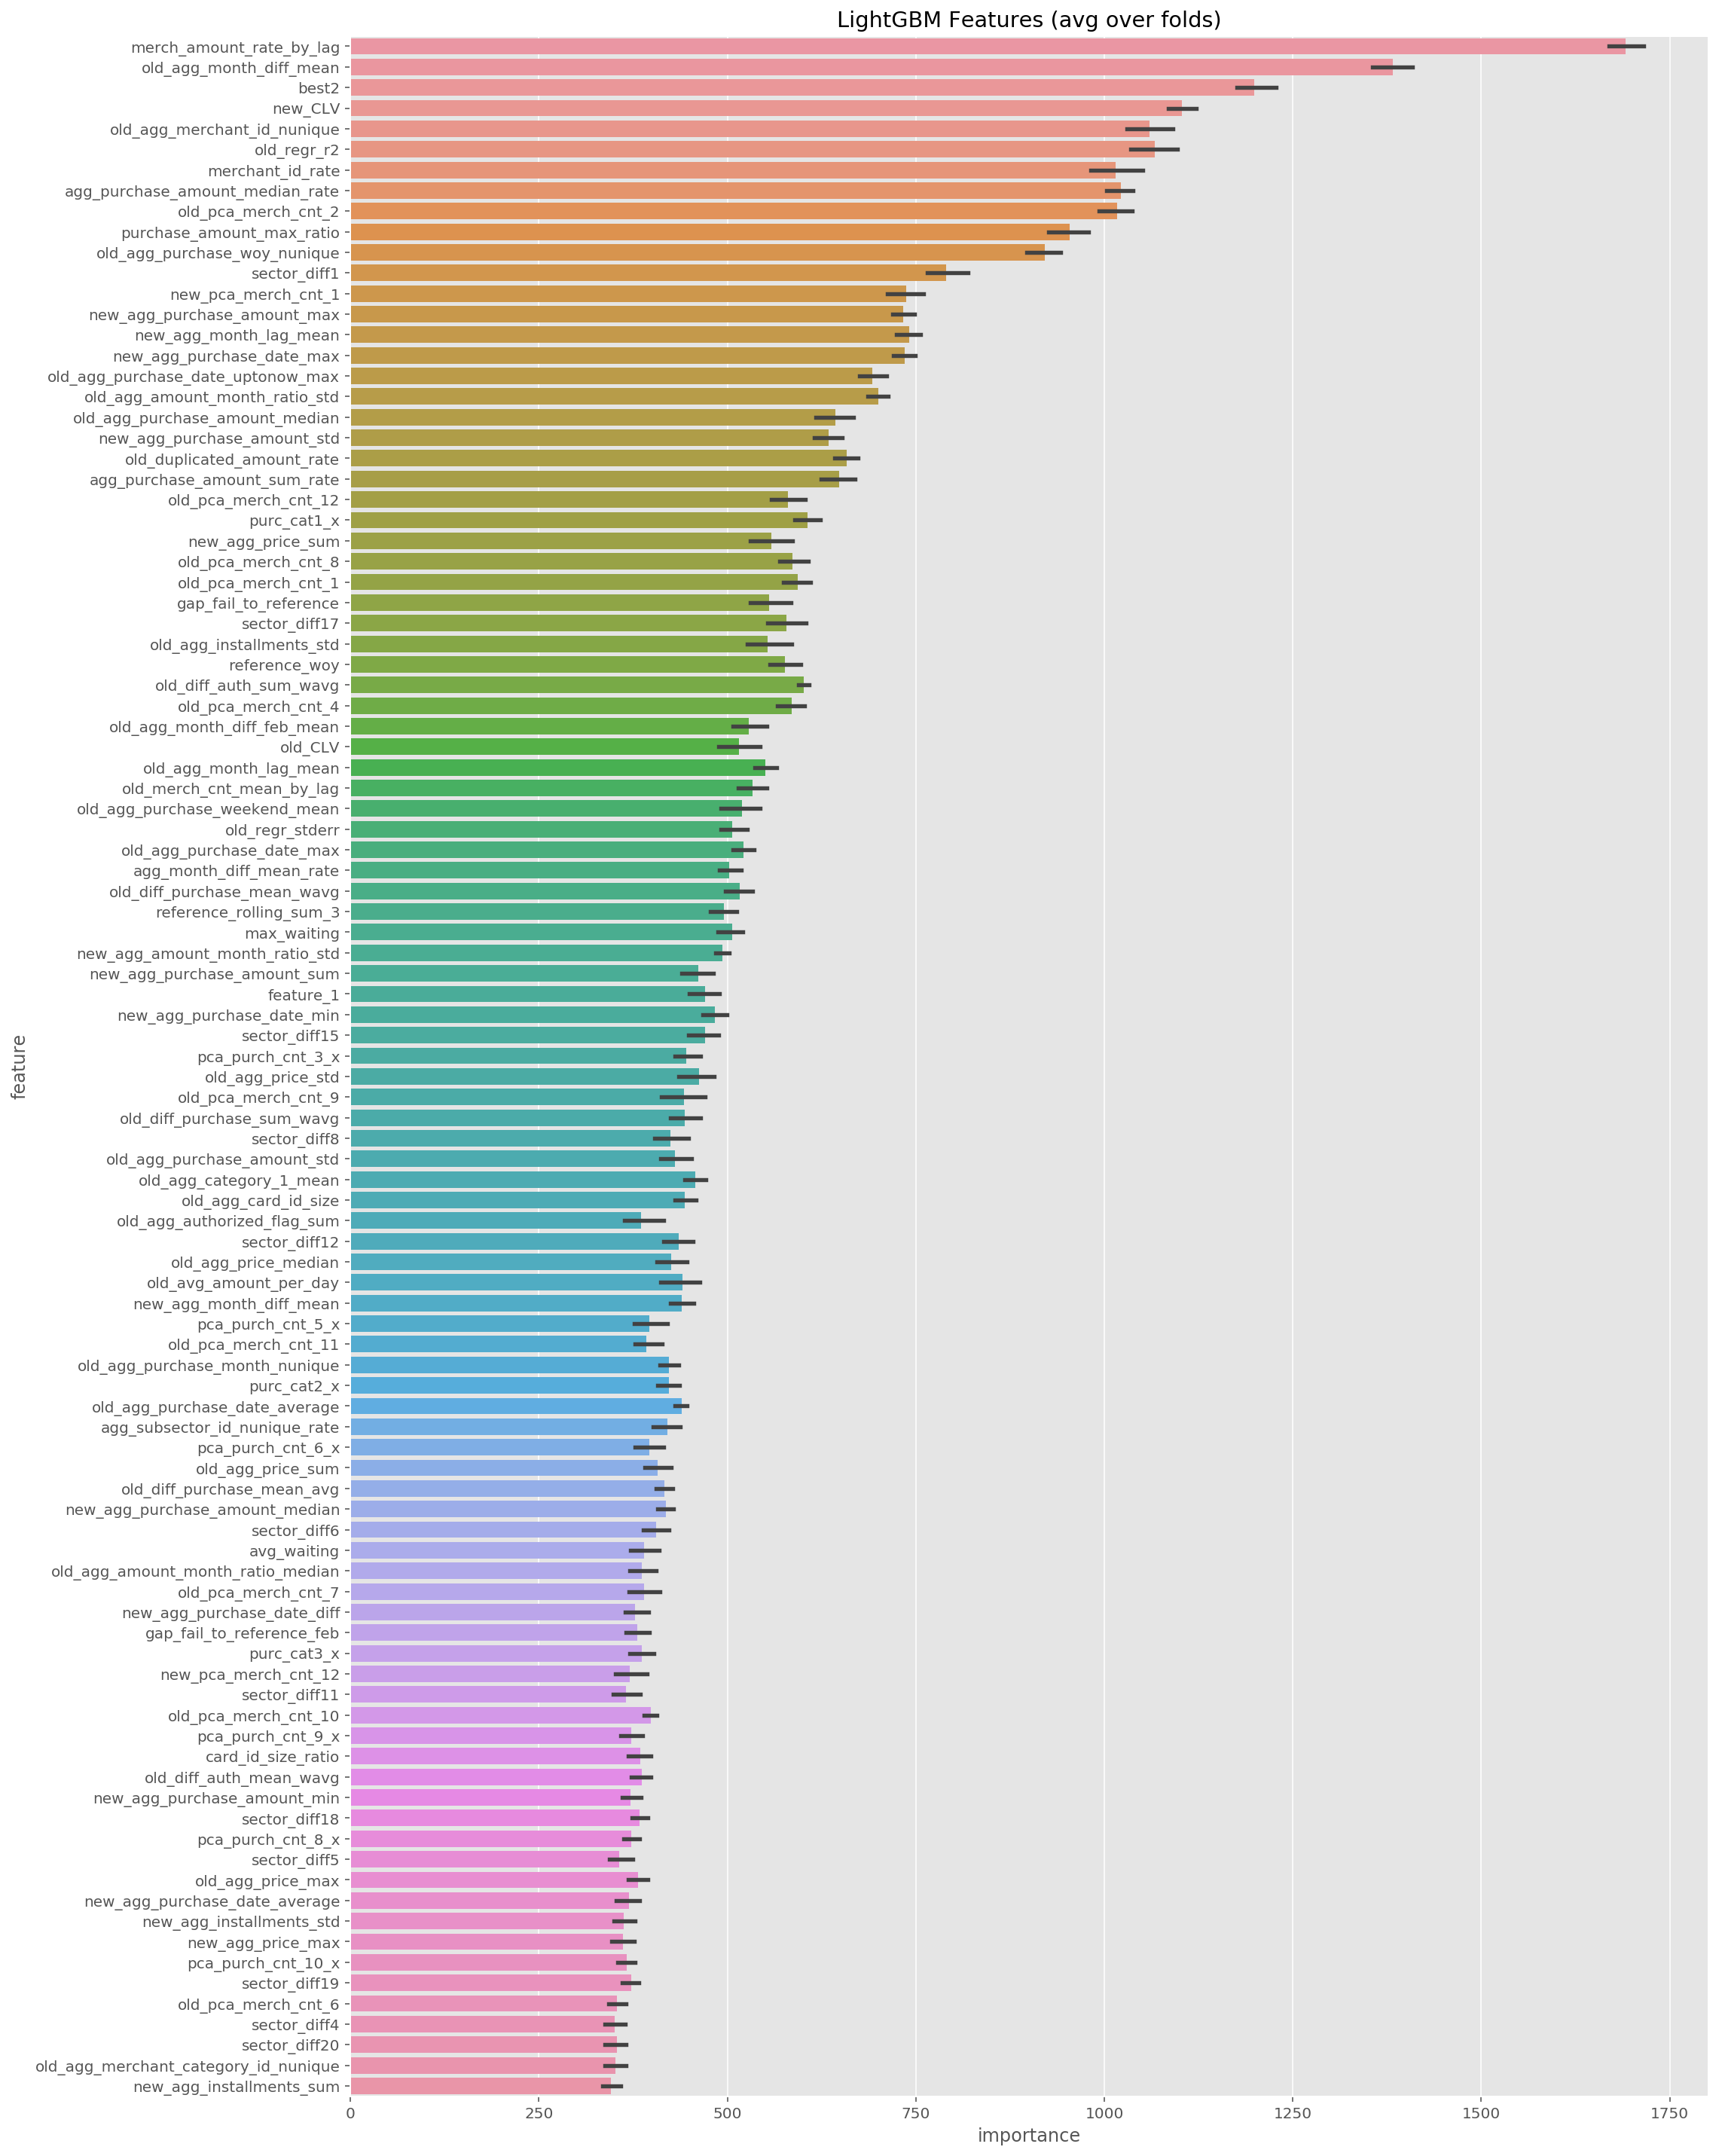

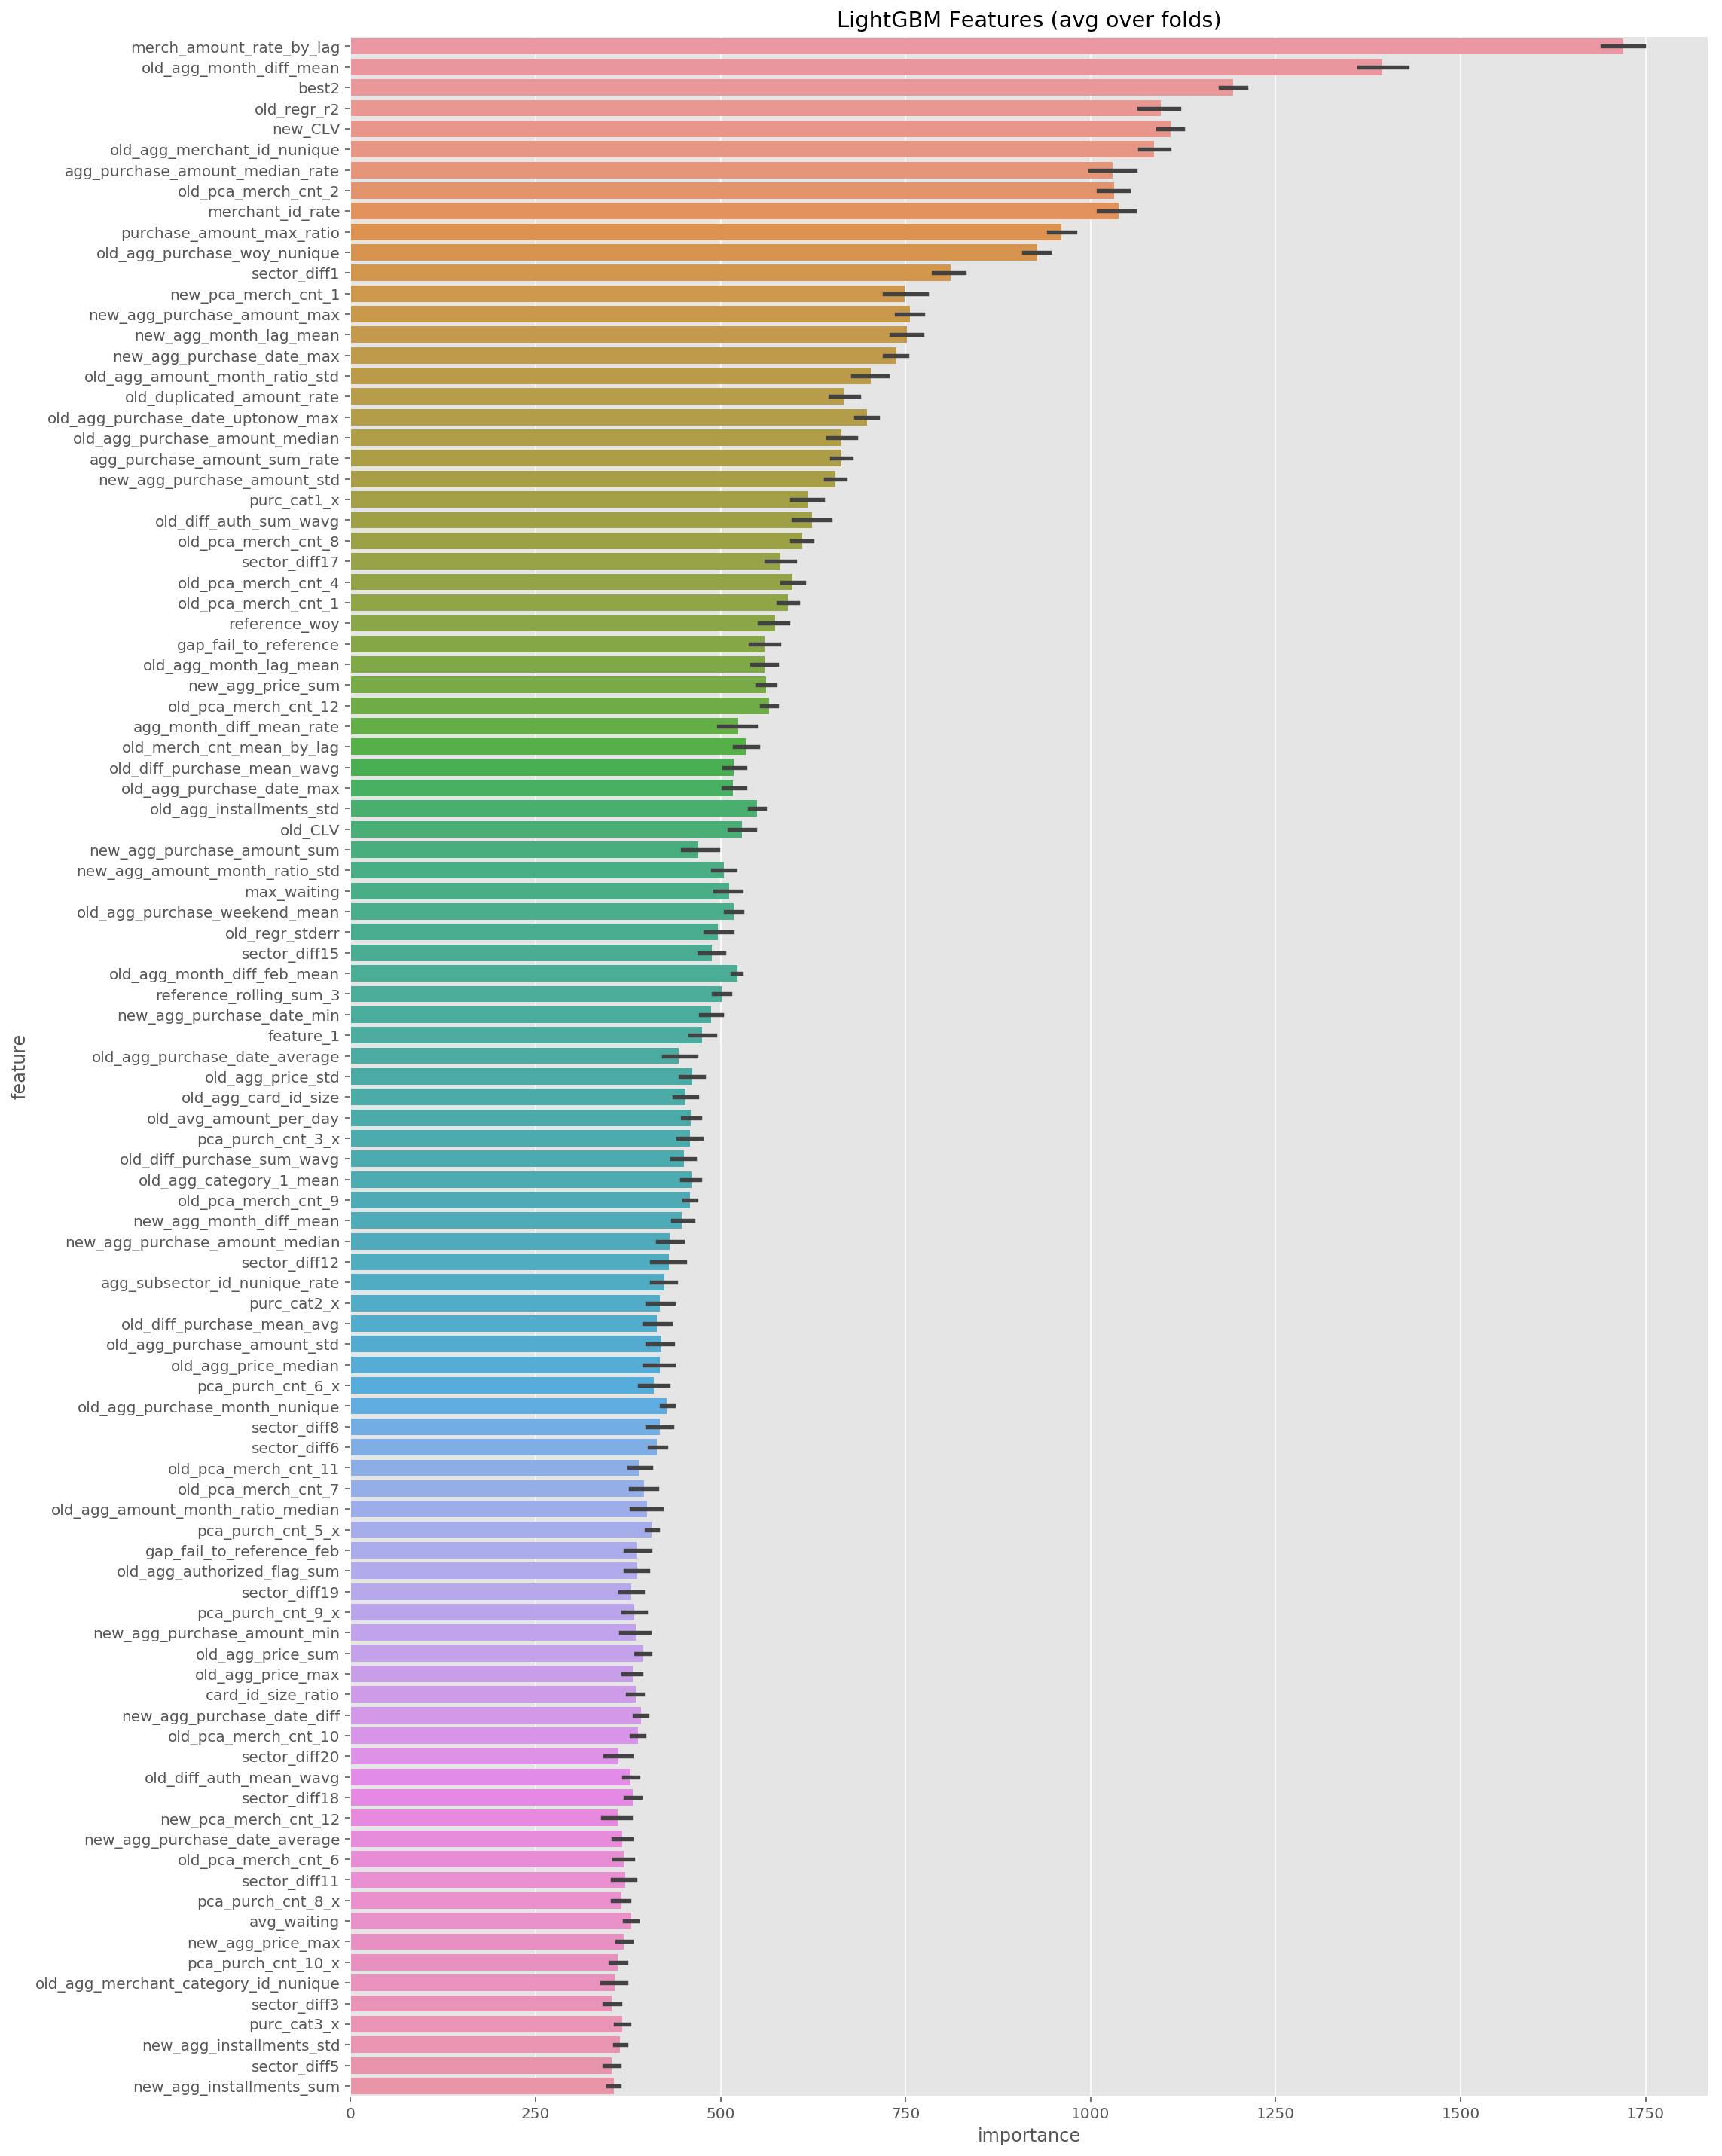

In [61]:
%%time

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 100,
    'max_depth': 7,
    'learning_rate': 0.008,
    'min_child_samples': 80,
    "reg_alpha": 0.3, 
    "reg_lambda": 0.1,
    "bagging_fraction": 0.8, 
    'feature_fraction': 0.8,
    'bagging_freq': 1,
    'bagging_seed': 0,
    'verbosity': -1,
    'n_jobs': 11,
}

df_train_noout = df_train[df_train['outliers'] == 0]
pred_wo_out = pd.DataFrame({'card_id': df_test['card_id'].values})


# OOF regression for train
# oof_wo_outliers = np.zeros(len(df_train_noout))

splits = [6, 8, 10]
bad_seeds = [0, 42, 2019]

for bad_seed, n_splits in zip(bad_seeds, splits):
    
    # custom shuffle strategy
    shuffle_train = custom_shuffle(df_train=df_train_noout, i_seed=bad_seed)
    
    # define train/test with selected features
    train_X = shuffle_train[big_features]
    train_y = shuffle_train['target']
    test_X = df_test[big_features]
    
    # define prediction variables as zero vecor
    prediction_tr = np.zeros(len(train_X))
    prediction_te = np.zeros(len(test_X))

    # feature importances df for all folds
    FI_df = pd.DataFrame()
    
    # KFold with custom shuffle
    folds = KFold(n_splits=n_splits, shuffle=False, random_state=bad_seed)
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X.values)):
        print('fold', fold_)

        trn_data = lgb.Dataset(train_X.iloc[trn_idx].values, label=train_y.iloc[trn_idx].values)
        val_data = lgb.Dataset(train_X.iloc[val_idx].values, label=train_y.iloc[val_idx].values)

        clf = lgb.train(
            params=lgb_params, 
            train_set=trn_data, 
            num_boost_round=1000,
            valid_sets=[trn_data, val_data], 
            verbose_eval=50, 
            early_stopping_rounds=100,
        )

        prediction_tr[val_idx] = clf.predict(train_X.iloc[val_idx].values, num_iteration=clf.best_iteration)
        prediction_te += clf.predict(test_X.values, num_iteration=clf.best_iteration)

        # feature importances
        fold_FI_df = pd.DataFrame()
        fold_FI_df['feature'] = list(train_X.columns)
        fold_FI_df['importance'] = clf.feature_importance()
        fold_FI_df['fold'] = fold_ + 1
        FI_df = pd.concat([FI_df, fold_FI_df], axis=0)

    prediction_te /= n_splits

    val_score = np.sqrt(mean_squared_error(train_y, prediction_tr))
    print(f'SCORE: {val_score}')
    
    cols = FI_df[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:100].index
    best_features_lgb = FI_df.loc[FI_df['feature'].isin(cols)].sort_values(by='importance', ascending=False)

    plt.figure(figsize=(16,20))
    sns.barplot(x='importance', y='feature', data=best_features_lgb)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    
    gc.collect()
    
    # predictions for test
    col_name = 'target_seed_' + str(bad_seed)
    pred_wo_out[col_name] = prediction_te
    
    # predictions for train
#     oof_wo_outliers += prediction_tr
    
# average OOF prediction among all seeds
# oof_wo_outliers /= len(bad_seeds)

In [62]:
sub_wo_33 = pd.DataFrame({"card_id": df_test["card_id"].values})
sub_wo_33["target"] = pred_wo_out.iloc[:, 1:].mean(axis=1)
sub_wo_33.head()

card_id    target
0  C_ID_0ab67a22ab -0.368688
1  C_ID_130fd0cbdd -0.329392
2  C_ID_b709037bc5 -0.990161
3  C_ID_d27d835a9f -0.033769
4  C_ID_2b5e3df5c2 -1.142413

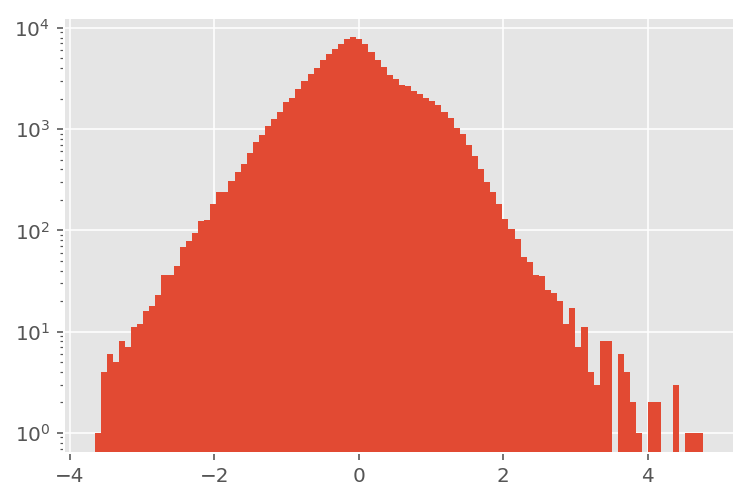

In [66]:
sub_wo_33['target'].hist(bins=100, log=True);

# Part 3. Forecast with outliers

Here we gonna use `outlier_prob_oof` as addditional feature in model.

custom_shuffle...
fold 0
Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 3.73004	valid_1's rmse: 3.74882
[100]	training's rmse: 3.65843	valid_1's rmse: 3.69883
[150]	training's rmse: 3.6121	valid_1's rmse: 3.67235
[200]	training's rmse: 3.57873	valid_1's rmse: 3.65757
[250]	training's rmse: 3.55323	valid_1's rmse: 3.64871
[300]	training's rmse: 3.53198	valid_1's rmse: 3.64329
[350]	training's rmse: 3.5151	valid_1's rmse: 3.63978
[400]	training's rmse: 3.50064	valid_1's rmse: 3.6374
[450]	training's rmse: 3.48774	valid_1's rmse: 3.63532
[500]	training's rmse: 3.47635	valid_1's rmse: 3.63415
[550]	training's rmse: 3.46564	valid_1's rmse: 3.63365
[600]	training's rmse: 3.45583	valid_1's rmse: 3.63321
[650]	training's rmse: 3.44602	valid_1's rmse: 3.63285
[700]	training's rmse: 3.4359	valid_1's rmse: 3.63262
[750]	training's rmse: 3.4263	valid_1's rmse: 3.63275
[800]	training's rmse: 3.41733	valid_1's rmse: 3.63278
Early stopping, best iteration is:
[71

[450]	training's rmse: 3.48995	valid_1's rmse: 3.62626
[500]	training's rmse: 3.47936	valid_1's rmse: 3.62481
[550]	training's rmse: 3.46949	valid_1's rmse: 3.62385
[600]	training's rmse: 3.46047	valid_1's rmse: 3.62322
[650]	training's rmse: 3.45127	valid_1's rmse: 3.62251
[700]	training's rmse: 3.44306	valid_1's rmse: 3.622
[750]	training's rmse: 3.43409	valid_1's rmse: 3.62135
[800]	training's rmse: 3.42607	valid_1's rmse: 3.62107
[850]	training's rmse: 3.41799	valid_1's rmse: 3.62114
[900]	training's rmse: 3.41061	valid_1's rmse: 3.62102
[950]	training's rmse: 3.40253	valid_1's rmse: 3.62105
Early stopping, best iteration is:
[863]	training's rmse: 3.4162	valid_1's rmse: 3.62091
fold 2
Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 3.72799	valid_1's rmse: 3.75863
[100]	training's rmse: 3.65648	valid_1's rmse: 3.71149
[150]	training's rmse: 3.60985	valid_1's rmse: 3.68624
[200]	training's rmse: 3.57571	valid_1's rmse: 3.67228
[250]	training's rm

[350]	training's rmse: 3.5172	valid_1's rmse: 3.62771
[400]	training's rmse: 3.50308	valid_1's rmse: 3.6247
[450]	training's rmse: 3.49077	valid_1's rmse: 3.62291
[500]	training's rmse: 3.47979	valid_1's rmse: 3.62149
[550]	training's rmse: 3.46947	valid_1's rmse: 3.62076
[600]	training's rmse: 3.45956	valid_1's rmse: 3.62012
[650]	training's rmse: 3.45054	valid_1's rmse: 3.6197
[700]	training's rmse: 3.44142	valid_1's rmse: 3.61932
[750]	training's rmse: 3.43274	valid_1's rmse: 3.61878
[800]	training's rmse: 3.42505	valid_1's rmse: 3.61876
[850]	training's rmse: 3.41705	valid_1's rmse: 3.61892
[900]	training's rmse: 3.40966	valid_1's rmse: 3.619
Early stopping, best iteration is:
[814]	training's rmse: 3.42262	valid_1's rmse: 3.61843
fold 1
Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 3.72981	valid_1's rmse: 3.75583
[100]	training's rmse: 3.65918	valid_1's rmse: 3.70621
[150]	training's rmse: 3.61352	valid_1's rmse: 3.67865
[200]	training's rmse

[200]	training's rmse: 3.58073	valid_1's rmse: 3.65454
[250]	training's rmse: 3.5556	valid_1's rmse: 3.64557
[300]	training's rmse: 3.53591	valid_1's rmse: 3.64058
[350]	training's rmse: 3.51919	valid_1's rmse: 3.63682
[400]	training's rmse: 3.50468	valid_1's rmse: 3.6342
[450]	training's rmse: 3.49297	valid_1's rmse: 3.63229
[500]	training's rmse: 3.48133	valid_1's rmse: 3.63081
[550]	training's rmse: 3.47146	valid_1's rmse: 3.63011
[600]	training's rmse: 3.46287	valid_1's rmse: 3.62918
[650]	training's rmse: 3.45323	valid_1's rmse: 3.62838
[700]	training's rmse: 3.44433	valid_1's rmse: 3.62737
[750]	training's rmse: 3.43502	valid_1's rmse: 3.62674
[800]	training's rmse: 3.42628	valid_1's rmse: 3.62623
[850]	training's rmse: 3.4187	valid_1's rmse: 3.62595
[900]	training's rmse: 3.41064	valid_1's rmse: 3.62535
[950]	training's rmse: 3.40288	valid_1's rmse: 3.62489
[1000]	training's rmse: 3.39536	valid_1's rmse: 3.62447
Did not meet early stopping. Best iteration is:
[1000]	training's r

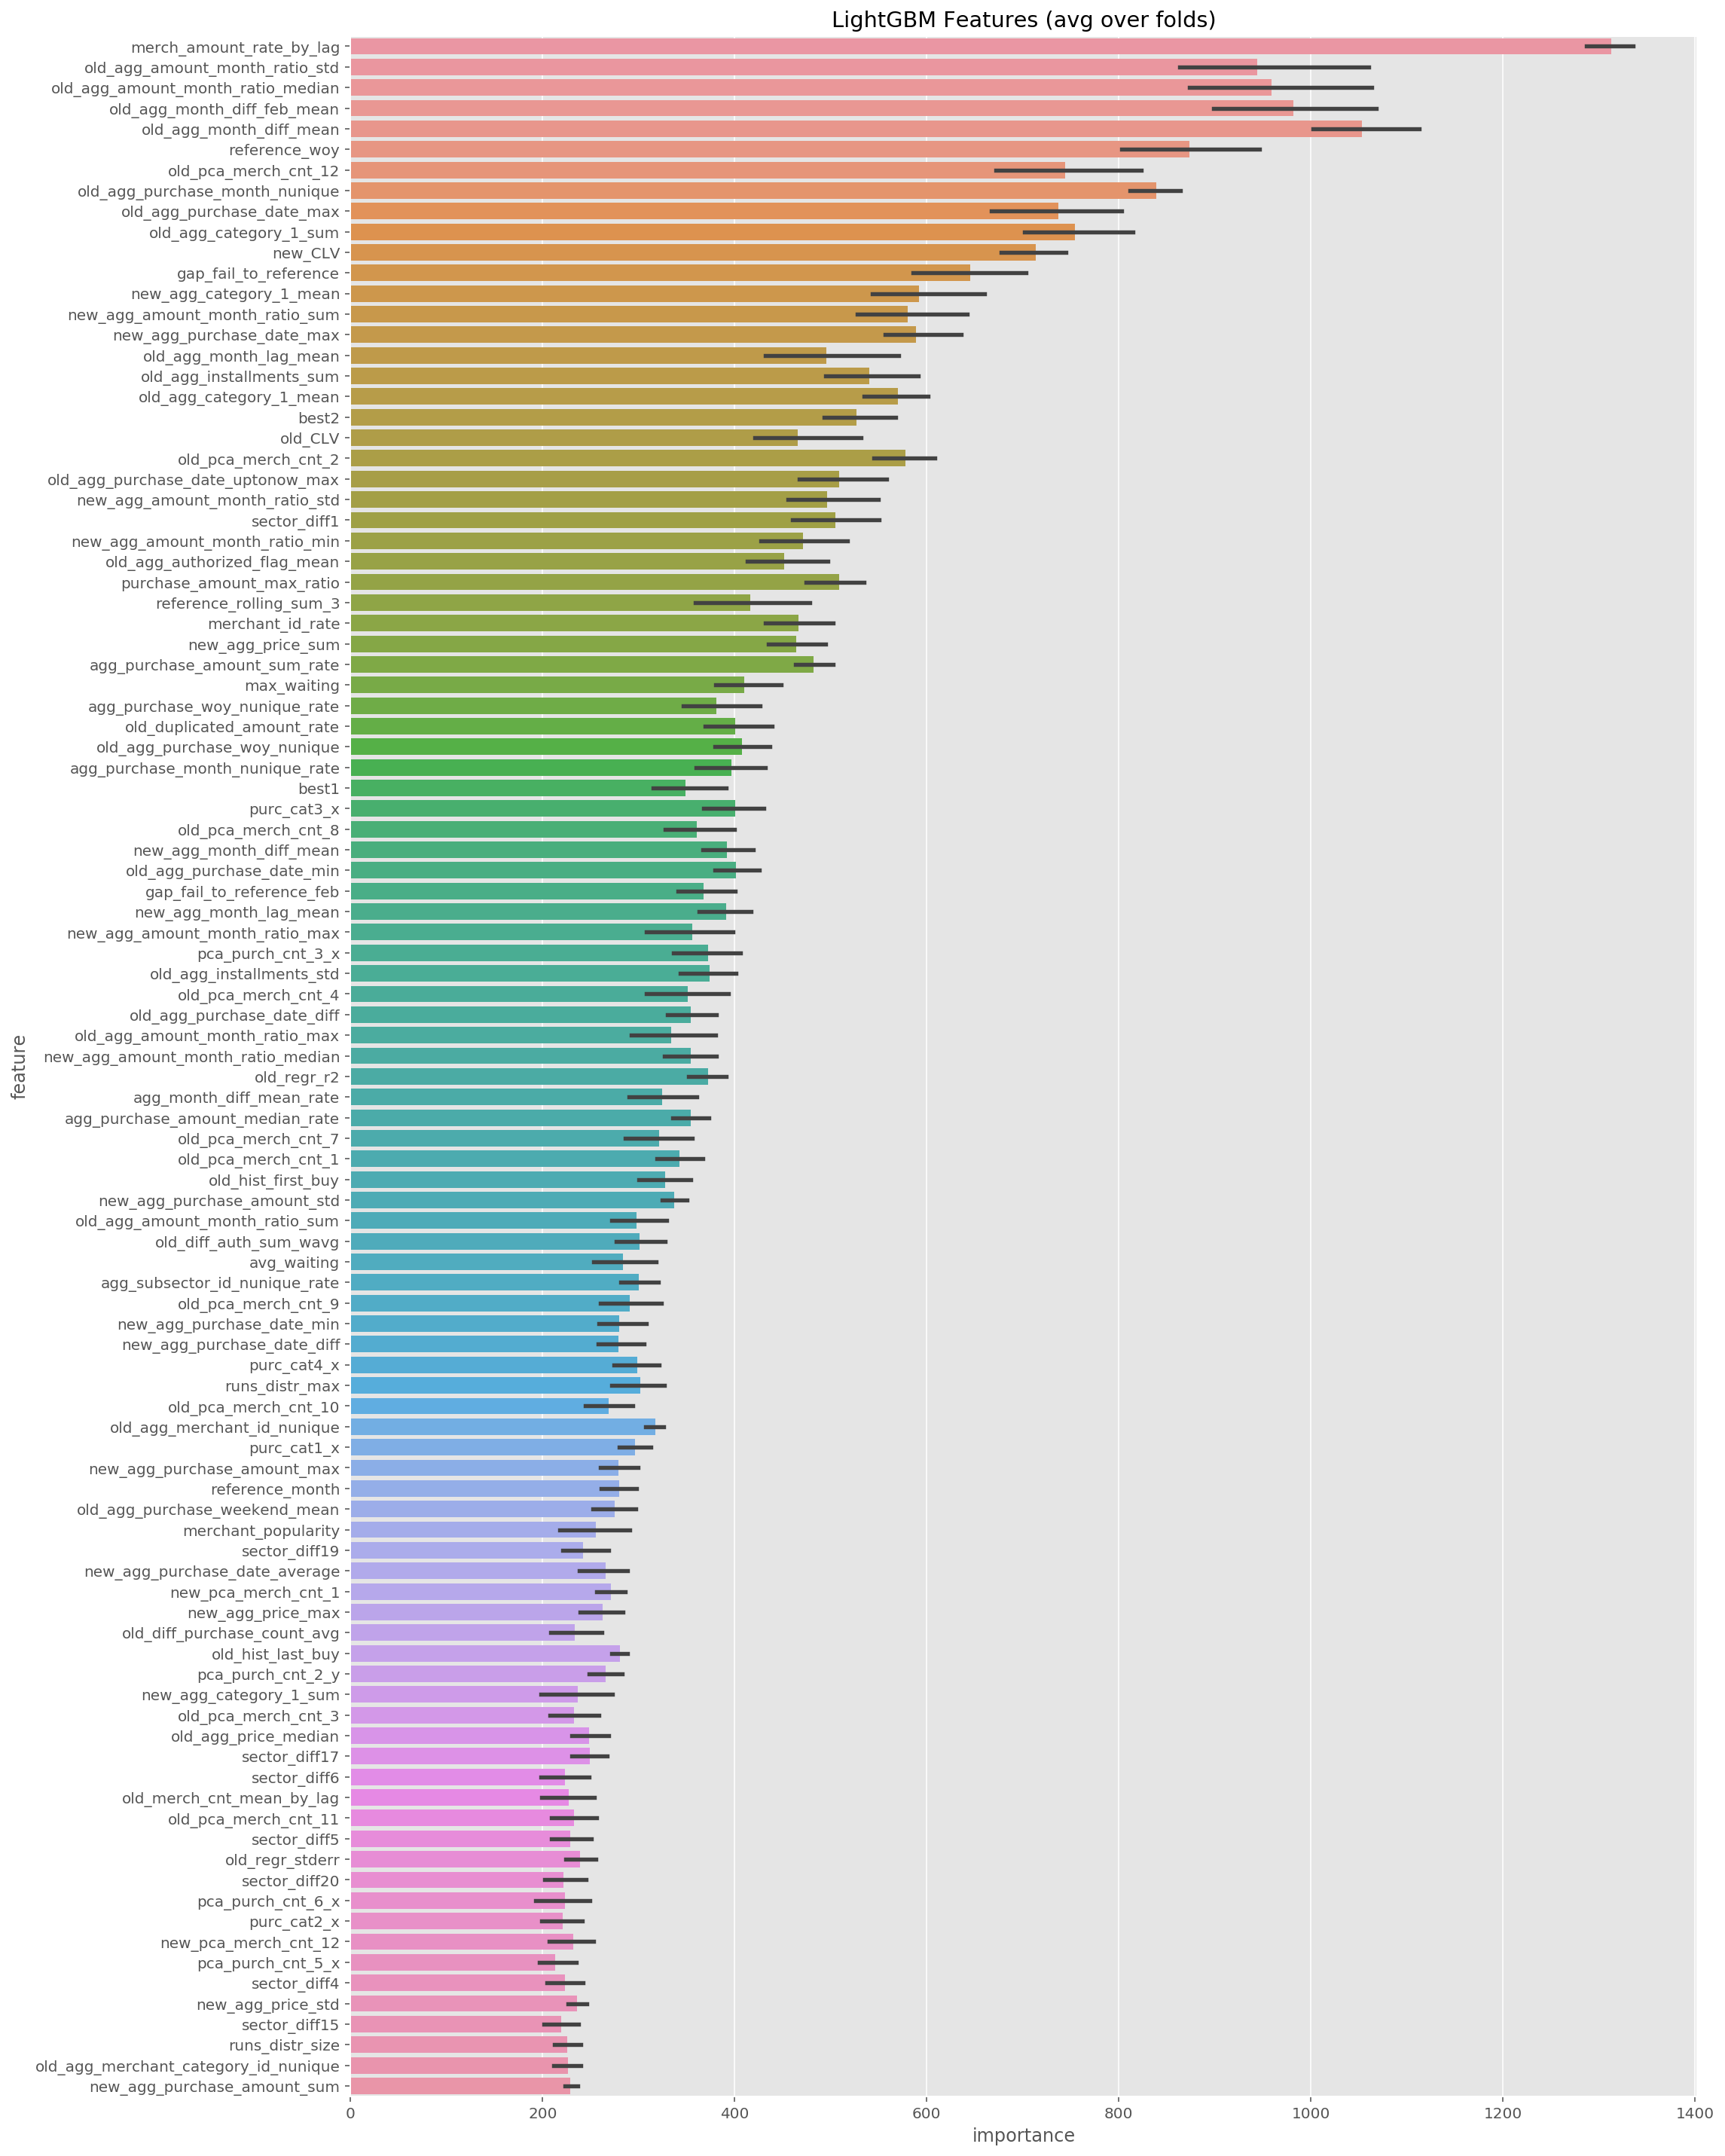

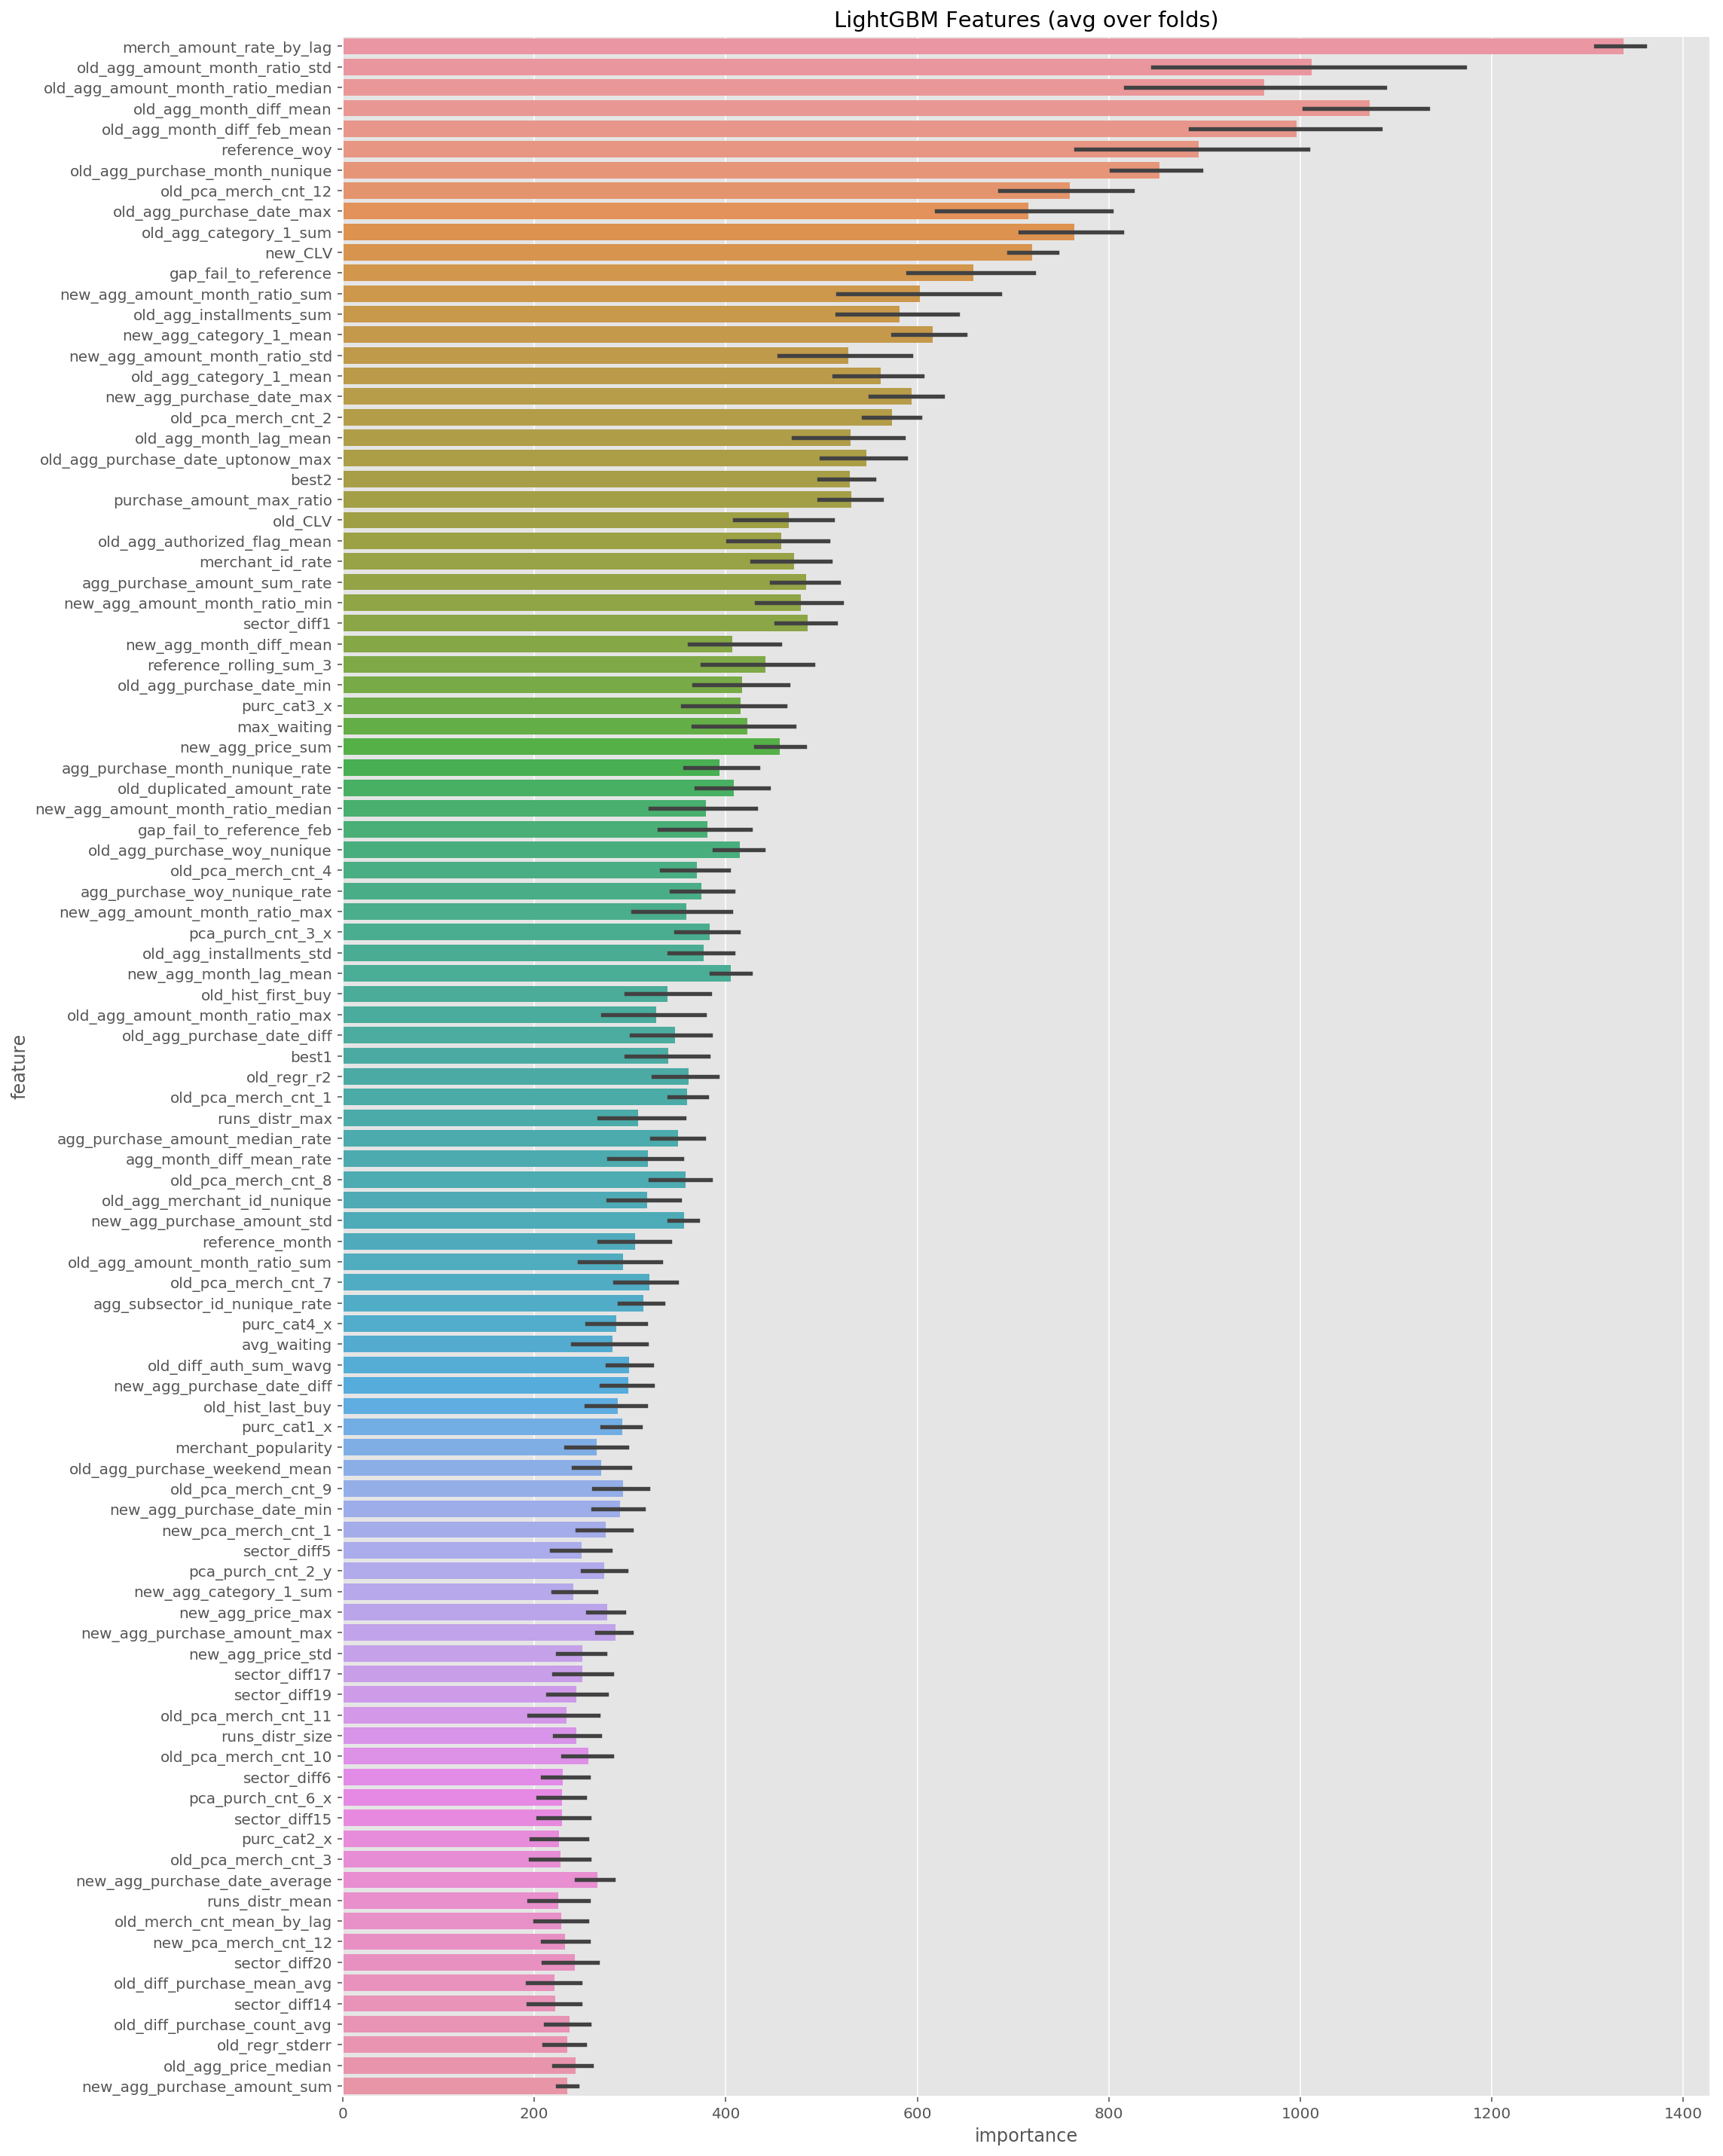

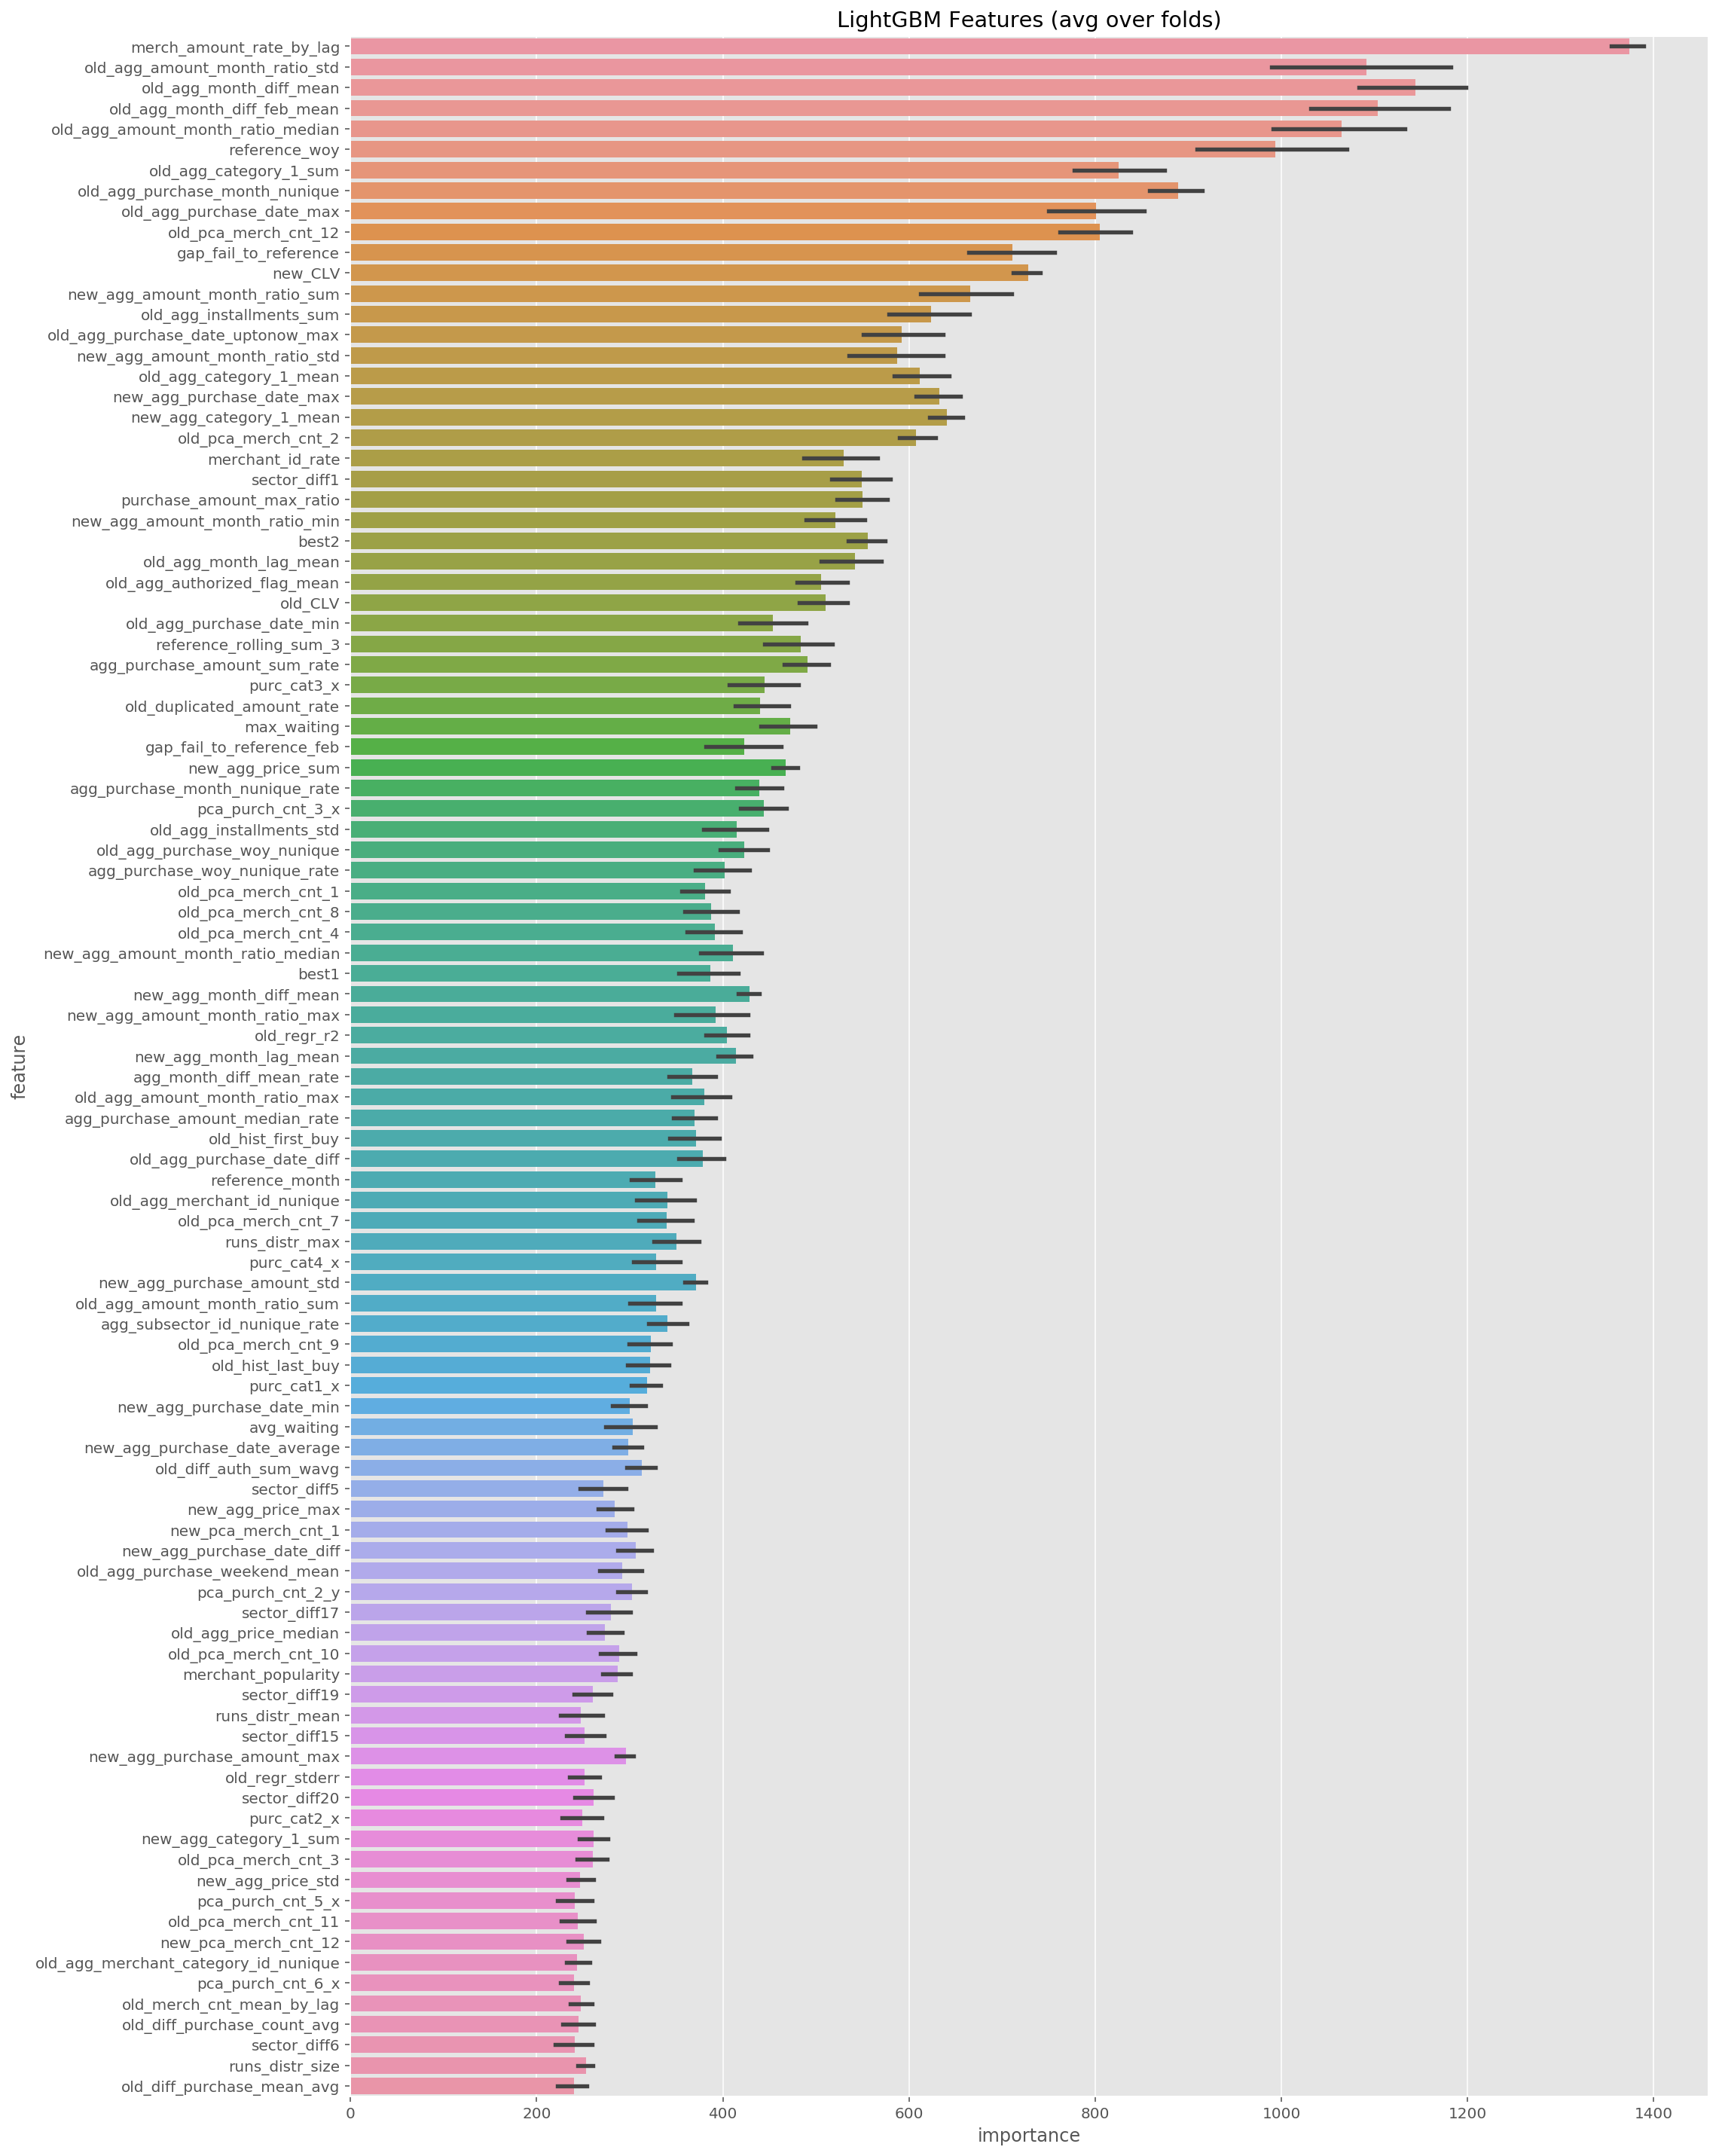

In [55]:
%%time

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 100,
    'max_depth': 7,
    'learning_rate': 0.008,
    'min_child_samples': 80,
    "reg_alpha": 0.3, 
    "reg_lambda": 0.1,
    "bagging_fraction": 0.8, 
    'feature_fraction': 0.8,
    'bagging_freq': 1,
    'bagging_seed': 0,
    'verbosity': -1,
    'n_jobs': 11,
}

pred_with_out = pd.DataFrame({'card_id': df_test['card_id'].values})

# OOF regression for train
# oof_with_outliers = np.zeros(len(big_features))

splits = [6, 8, 10]
bad_seeds = [0, 42, 2019]

for bad_seed, n_splits in zip(bad_seeds, splits):
    
    # custom shuffle strategy
    shuffle_train = custom_shuffle(df_train=df_train, i_seed=bad_seed)
    
    # define train/test with selected features
#     train_X = shuffle_train[big_features + ['oof_prob']]
    train_X = shuffle_train[big_features]
    train_y = shuffle_train['target']
#     test_X = df_test[big_features + ['oof_prob']]
    test_X = df_test[big_features]
    
    # define prediction variables as zero vecor
    prediction_tr = np.zeros(len(train_X))
    prediction_te = np.zeros(len(test_X))

    # feature importances df for all folds
    FI_df = pd.DataFrame()
    
    # KFold with custom shuffle
    folds = KFold(n_splits=n_splits, shuffle=False, random_state=bad_seed)
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X.values)):
        print('fold', fold_)

        trn_data = lgb.Dataset(train_X.iloc[trn_idx].values, label=train_y.iloc[trn_idx].values)
        val_data = lgb.Dataset(train_X.iloc[val_idx].values, label=train_y.iloc[val_idx].values)

        clf = lgb.train(
            params=lgb_params, 
            train_set=trn_data, 
            num_boost_round=1000,
            valid_sets=[trn_data, val_data], 
            verbose_eval=50, 
            early_stopping_rounds=100,
        )

        prediction_tr[val_idx] = clf.predict(train_X.iloc[val_idx].values, num_iteration=clf.best_iteration)
        prediction_te += clf.predict(test_X.values, num_iteration=clf.best_iteration)

        # feature importances
        fold_FI_df = pd.DataFrame()
        fold_FI_df['feature'] = list(train_X.columns)
        fold_FI_df['importance'] = clf.feature_importance()
        fold_FI_df['fold'] = fold_ + 1
        FI_df = pd.concat([FI_df, fold_FI_df], axis=0)

    prediction_te /= n_splits

    val_score = np.sqrt(mean_squared_error(train_y, prediction_tr))
    print(f'SCORE: {val_score}')
    
    cols = FI_df[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:100].index
    best_features_lgb = FI_df.loc[FI_df['feature'].isin(cols)].sort_values(by='importance', ascending=False)

    plt.figure(figsize=(16,20))
    sns.barplot(x='importance', y='feature', data=best_features_lgb)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    
    # predictions for test
    col_name = 'target_seed_' + str(bad_seed)
    pred_with_out[col_name] = prediction_te
    
    # predictions for train
    # oof_with_outliers += prediction_tr
    
    gc.collect()
    
# average OOF prediction among all seeds
# oof_with_outliers /= len(bad_seeds)

In [56]:
sub_df = pd.DataFrame({"card_id": df_test["card_id"].values})
sub_df["target"] = pred_with_out.iloc[:, 1:].mean(axis=1)
sub_df.to_csv("best_dirt_model.csv", index=False)
sub_df.head()

card_id    target
0  C_ID_0ab67a22ab -1.338004
1  C_ID_130fd0cbdd -0.279343
2  C_ID_b709037bc5 -1.189640
3  C_ID_d27d835a9f -0.065454
4  C_ID_2b5e3df5c2 -1.132886

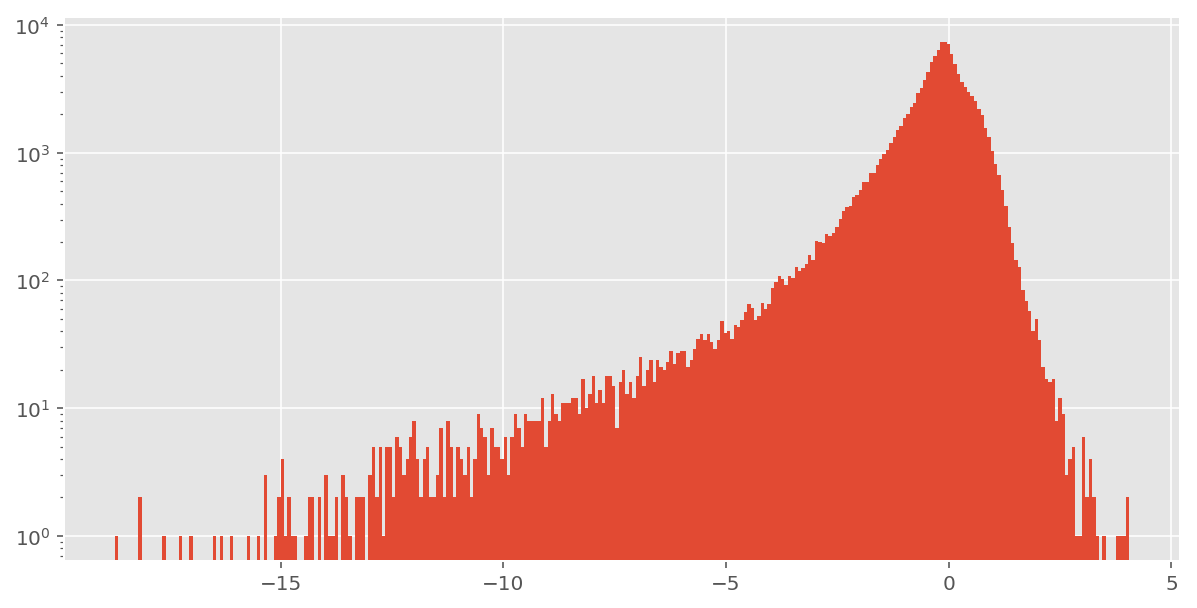

In [57]:
sub_df["target"].hist(bins=300, log=True, figsize=(10,5));

### Part 3 Combining Submission:

So far so good ! We now have three dataset:

    Best Submission
    Prediction Using Model Without Outliers
    Probability of Outliers In Test set

In [76]:
topn = 0 

# In case missing some predictable outlier, we choose top 25000 with highest outliers likelyhood.
outlier_id = pd.DataFrame(df_outlier_prob.sort_values(by='target', ascending = False).head(27000)['card_id'])[topn:]

# choose topn from outlier_id
outlier_id_topn = pd.DataFrame(df_outlier_prob.sort_values(by='target', ascending = False).head(27000)['card_id'])[:topn]
outlier_id_topn['target'] = -33.21928095 * np.ones(topn)

In [77]:
# model 1.56 (without -33)
model_1 = sub_wo_33.set_index('card_id')

# model 3.64 (with -33)
model_2 = sub_df.merge(outlier_id, how='right').set_index('card_id')

# manual outliers
model_3 = outlier_id_topn.set_index('card_id')

In [78]:
model_1.loc[model_2.index, 'target'] = model_2['target'].values
model_1.loc[model_3.index, 'target'] = model_3['target'].values

model_1.reset_index(inplace=True)

In [79]:
model_1.to_csv("combining_submission-24022019_3.csv", index=False)

In [29]:
plt.figure(figsize=(10,5))
model_1['target'].hist(bins=300, log=True);